# PRODUCTIVIDAD_beta

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import dateparser 
import matplotlib.pyplot as plt

import seaborn as sns

import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from datetime import datetime, timedelta,date
%matplotlib inline

import timeit
import warnings

plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 20})

sns.set_context("paper", font_scale=2.5)  


#########################################                            ########################################




########################################          PRODUCTIVIDAD     #########################################




########################################                            #########################################






##################    CARGA DE BASE DE DATOS DE CNH   ######################

def carga_bd():
    
    global mx_bd
    global mx_reservas
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_full.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado_actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_de_perforacion',
                                  'tipo_de_hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'contrato'],
                                  low_memory=True)
            
    mx_reservas=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_reservas.csv',
                          index_col=0)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')


##################    FUNCIÓN DE PRODUCTIVIDAD   ######################

def productividad():
    
    global perfil
    global df
    global tipo1
    global tipo2
    global tipo3
    global parametros
    global tipos
    
    tic=timeit.default_timer()
    
    global alta, media, baja
    
    alta=0.90
    media=0.50
    baja=0.30
    
##################    INPUT CAMPO   ######################
    
    #input de campo de analisis
    def campo_analisis():
        
        global input_campo, input_hidrocarburo, input_fecha
        global pozos
        global len_proy
        global nequip
        global cap
        global reservas_aceite, info_reservas
        global num_pozos
        global pozos_tipo1,pozos_tipo2,pozos_tipo3
        global regimen_fiscal, regalia_adicional, region_fiscal
        global lista_pozos
        
        #SECCION DE INPUTS
        
        #INPUT DE CAMPO
        input_campo = str(input("Nombre de campo: "))
        
        #SUBSET DE LA BASE DE DATOS POR CAMPO/POZO
        pozos=pd.DataFrame()

        seleccion_pozo=mx_bd.pozo.str.contains(pat=input_campo,regex=True)
        seleccion_campo=mx_bd.campo.str.match(pat=input_campo)
        pozos=mx_bd.loc[seleccion_campo & seleccion_pozo]
        
        seleccion_reservas=mx_reservas.NOMBRE.str.match(pat=input_campo)
        info_reservas=mx_reservas.loc[seleccion_reservas]
        #info_reservas=mx_reservas[mx_reservas.NOMBRE == str(input_campo)]
        
        lista_pozos=list(pd.unique(pozos['pozo']))

        display('Número de pozos en ' +str(input_campo)+': '+str(len(lista_pozos)))
        
        #INPUT DE RANGO DE MUESTRA
        
        input_fecha=input("Tomar muestra desde fecha (yyyy-mm-dd): ")

        if input_fecha == str(''):
            input_fecha='2000-01-01'
            
        input_fecha=pd.Timestamp(input_fecha)
        
        #INPUTS ECONOMICOS
        
        #Regimen Fiscal especificar si es "licencia", "cpc" o "asignacion" 
        regimen_fiscal = input("Régimen Fiscal: ") #"licencia"
        regimen_fiscal = str(regimen_fiscal)
        
        if regimen_fiscal == str(''):
            regimen_fiscal = 'licencia'
        
        if regimen_fiscal not in ["licencia","cpc","asignacion"]:
             raise SystemExit("Párametro Inválido")

        if regimen_fiscal == "licencia":
            regalia_adicional = input("Regalía Adicional Decimales: ") #En decimales el porcentaje de regalía adicional para los contratos de licencia
            
            if regalia_adicional == str(''):
                regalia_adicional = float(0.10)
            else:
                regalia_adicional = float(regalia_adicional)

        #Region fiscal: aceite_terrestre, aguas_someras, aguas_profundas, gas, chicontepec 
        #region_fiscal =  input("Región Fiscal: ") #"aceite_terrestre"   
        #region_fiscal=str(region_fiscal)
        #if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
         #   raise SystemExit("Párametro Inválido")

        if pozos.cuenca.str.contains('TAMPICO-MISANTLA').any() == True:
                region_fiscal = 'chicontepec'
        
        if pozos.cuenca.str.contains('VERACRUZ').any() == True:
            if pozos.tipo_de_hidrocarburo.str.contains('GAS').any() == True: 
                region_fiscal = 'gas'
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.cuenca.str.contains('BURGOS' or 'SABINAS').any() == True:
            if pozos.tipo_de_hidrocarburo.str.contains('GAS').any() == True:
                region_fiscal = 'gas' 
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.cuenca.str.contains('CUENCAS DEL SURESTE').any() == True:
            if pozos.ubicacion.str.contains('MARINO').any() == True:
                region_fiscal = 'aguas_someras'
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.ubicacion.str.contains('AGUAS PROFUNDAS').any() == True :
            region.fiscal = 'aguas_profundas'

        if pozos.cuenca.str.contains('CINTURON PLEGADO DE CHIAPAS').any() == True:
            region.fiscal = 'aceite_terrestre'

        if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
            raise SystemExit("Párametro Inválido")

    
         #ARCHIVO CSV CON BASE DE DATOS DE POZOS
        #pozos.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))
        
        
        #INPUTS DE VARIABLES DE EVALUACION
        
        #duracion=int(input('Duracion del contrato (años): '))
        #nequip=input('Numero de equipos: ')
        #cap=input('Capacidad de procesamiento (Mbd: ')
        #reservas=input('Reservas: ')
        
        len_proy=0
        duracion=30
        len_proy=duracion*12
        num_pozos=6
        nequip=1
        cap=1_000
        reservas_aceite=float(info_reservas['CRUDO 2P (MMB)'].sum())
        reservas_gas=float(info_reservas['GAS NATURAL 2P (MMBPCE)'].sum())
        
        pozos_tipo1=np.round(num_pozos*baja,0)
        pozos_tipo2=np.round(num_pozos*media,0)
        pozos_tipo3=num_pozos-(pozos_tipo1+pozos_tipo2)

        return len_proy, nequip, cap, reservas_aceite, num_pozos
    

##########################      FUNCIONES PARA EL ANALISIS DE DECLINACION DE POZOS      ########################## 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
 
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):

        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hiperbolica(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponencial(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonica(t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot serie_campo
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    
#############     ANÁLISIS DE DECLINACION DE POZOS (DCA)   #############

    def analisis_dca():
        
        global unique_well_list
        global serie_campo, serie_muestra, serie_status
        global serie_base, Q_base, G_base, C_base
        global hidrocarburo, gas, condensado
        global gasto
        global estadistica, acumulados, resumen_produccion, produccion_mensual, pico
        
        serie_campo=pd.DataFrame()
        serie_muestra=pd.DataFrame()
        serie_base=pd.DataFrame()
        serie_status=pd.DataFrame()
        Qi=pd.DataFrame()
        gasto=pd.DataFrame()
        
        #Entrada de campo de análisis
        campo_analisis()
        data_pozos=pozos
        
        #Limpieza de datos y formato de fecha
        data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
        
        #Hidrocarburos de análisis
        if data_pozos.aceite_Mbd.sum() > data_pozos.gas_no_asociado_MMpcd.sum():
            
            hidrocarburo='aceite_Mbd'
            gas='gas_asociado_MMpcd'
            
        else:
            
            hidrocarburo='gas_no_asociado_MMpcd'
            gas='gas_no_asociado_MMpcd'
        
        condensado='condensado_Mbd'
        
        #Remove all rows with null values in the desired time series column
        data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hidrocarburo)
        
        #Get a list of unique wells to loop through
        unique_well_list=list(pd.unique(data_pozos.pozo))
        
        #Get the earliest RecordDate for each Well
        data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')
        #Generate column for time online delta
        data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                      date_first_online_column='first_oil')
        
        #Generacion de dataframes por rangos de fechas de análisis
        data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2020-02-01')]
        pozos_desde=data_pozos[(data_pozos.first_oil>=input_fecha) & (data_pozos.first_oil<='2020-02-01')]
        
        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_well_list:
            
            #Subset del data frame del campo por pozo
            serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
            serie_produccion=serie_produccion.set_index('pozo')
            
            serie_desde=pozos_desde[pozos_desde.pozo==pozo]
            serie_desde=serie_desde.set_index('pozo')
            
            #Calculo de declinacion porcentual
            serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
            
            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hidrocarburo, 'fecha')
            qi_g=get_max_initial_production(serie_produccion, 500, gas, 'fecha')
            qi_c=get_max_initial_production(serie_produccion, 500, condensado, 'fecha')

            if qi_g == 0:
                qi_g = 0.00000000000000000000000000000000000000000001
            
            if qi_c == 0:
                qi_c = 0.00000000000000000000000000000000000000000001
                
            qi_desde=get_max_initial_production(serie_desde, 500, hidrocarburo, 'fecha')
            qi_g_desde=get_max_initial_production(serie_desde, 500, gas, 'fecha')
            qi_c_desde=get_max_initial_production(serie_desde, 500, condensado, 'fecha')

            if qi_g_desde == 0:
                qi_g_desde = 0.00000000000000000000000000000000000000000001
            
            if qi_c_desde == 0:
                qi_c_desde = 0.00000000000000000000000000000000000000000001
            
            
            #Resultados de Qi historica
            serie_produccion.loc[:,'Qi_hist']=qi
            serie_desde['Qi_desde']=qi_desde
            
            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
            serie_desde['mes']=(serie_desde[hidrocarburo] > 0).cumsum()
            
            #serie_produccion.loc[:,'produccion_mensual']=serie_produccion[hidrocarburo]*30/1000
            #serie_produccion.loc[:,'produccion_acumulada']=serie_produccion.produccion_mensual.cumsum()
    
            #Ajuste Exponencial
            popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
                                        serie_produccion[hidrocarburo],bounds=(0, [qi,10]))
            
                        
            popt_exp_g, pcov_exp_g=curve_fit(exponencial, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,10]))
            
            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,1,10]))
            
            popt_hyp_g, pcov_hyp_g=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,1,50]))
            
            popt_hyp_c, pcov_hyp_c=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[condensado],bounds=(0.0, [qi_c,1,10]))
            
            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
           
            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,20]))
            
            popt_harm_g, pcov_harm_g=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,20]))
            
            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
    
            #Resultados de funcion Exponencial
            serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
                                  *popt_exp)
            
            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)
            
            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)
            
            #Resultados de funcion Gas
            serie_produccion.loc[:,'gas_hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp_g)
            
            serie_produccion.loc[:,'gas_harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm_g)
                                    
            serie_produccion.loc[:,'gas_exponencial']=exponencial(serie_produccion['mes'], 
                                      *popt_exp_g)    
            
            #Resultados de funcion Condensado
            serie_produccion.loc[:,'condensado']=hiperbolica(serie_produccion['mes'], 
                                     *popt_hyp_c)
            
            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
            perr_exp = np.sqrt(np.diag(pcov_exp))
                
            seleccion_status=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            seleccion_base=serie_produccion[serie_produccion.fecha >= '2020-01-01']
            
            Qi=[[pozo,
                 qi,
                 popt_hyp[0],
                 popt_hyp[1],
                 popt_hyp[2],
                 perr_hyp[0],
                 perr_hyp[1],
                 popt_harm[0],
                 popt_harm[1],
                 perr_harm[0],
                 perr_harm[1],
                 popt_exp[0],
                 popt_exp[1],
                 perr_exp[0],
                 perr_exp[1],
                 float(seleccion_status.get_value(pozo,hidrocarburo)),
                 serie_produccion.fecha.max(),
                 serie_produccion.loc[:,'mes'].max(),
                 float(seleccion_status.get_value(pozo,'profundidad_vertical')),
                 str(seleccion_status.get_value(pozo,'trayectoria')),
                 seleccion_status.get_value(pozo,'first_oil'),
                 popt_hyp_g[0],
                 popt_hyp_g[1],
                 popt_hyp_g[2],
                 popt_hyp_c[0],
                 popt_hyp_c[1],
                 popt_hyp_c[2],
                 str(seleccion_status.get_value(pozo,'estado_actual'))]]
    
            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hidrocarburo,'harmonica','hiperbolica']
            x_variable='mes'
            
            #Create the plot title
            plot_title=hidrocarburo+' for '+str(pozo)
            
            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)
                
            #Resultados de DCA
            serie_campo=serie_campo.append(serie_produccion,sort=False)
            serie_muestra=serie_muestra.append(serie_desde)
            gasto=gasto.append(Qi,sort=True)
            serie_status=serie_status.append(seleccion_status)
            serie_base=serie_base.append(seleccion_base)
            
        
        gasto=gasto.rename(columns={0:'pozo',
                                    1:'Qi_hist',
                                    2:'Qi_hyp',
                                    3:'b',
                                    4:'di_hyp',
                                    5:'error_Qi_hyp',
                                    6:'error_di_hyp',
                                    7:'Qi_harm',
                                    8:'di_harm',
                                    9:'error_Qi_harm',
                                   10:'error_di_harm',
                                   11:'Qi_exp',
                                   12:'di_exp',
                                   13:'error_Qi_exp',
                                   14:'error_di_exp', 
                                   15:'ultima_produccion',
                                   16:'ultima_fecha',
                                   17:'mes_max',
                                   18:'profundidad_vertical',
                                   19:'trayectoria',
                                   20:'first_oil',
                                   21:'Qi_gas',
                                   22:'b_gas',
                                   23:'di_gas',
                                   24:'Qi_condensado',
                                   25:'b_condensado',
                                   26:'di_condensado',
                                   27:'estado_actual'})
        
        estadistica=serie_campo.describe()
        
        Np=(serie_campo.aceite_Mbd.sum()*30)/1_000
        Gp=((serie_campo.gas_asociado_MMpcd.sum()+serie_campo.gas_no_asociado_MMpcd.sum())*30)/1_000
        Cp=(serie_campo.condensado_Mbd.sum()*30)/1_000
        Wp=(serie_campo.agua_Mbd.sum()*30)/1_000
                
        if float(info_reservas['PRODUCCION ACUMULADA CRUDO (MMB)'].sum()) > Np:
            Np = float(info_reservas['PRODUCCION ACUMULADA CRUDO (MMB)'].sum())
            
        if float(info_reservas['PRODUCCION ACUMULADA GAS (MMMPC)'].sum()) > Gp:
            Gp = float(info_reservas['PRODUCCION ACUMULADA GAS (MMMPC)'].sum())
        
        if  info_reservas['VO CRUDO 1P (MMB)'].empty == True & info_reservas['VO GAS 1P (MMMPC)'].empty == True:
            OOIP = float(0)
            Fr_aceite = float(0)
            OGIP = float(0)
            Fr_gas = float(0) 

        else:
            OOIP = float(info_reservas['VO CRUDO 1P (MMB)'].sum())
            OGIP = float(info_reservas['VO GAS 1P (MMMPC)'].sum())
            Fr_aceite = float(Np/OOIP)
            Fr_gas = float(Gp/OGIP)
            
        acumulados=pd.Series()
        acumulados=pd.Series(name=input_campo,
                             data=[Np, Gp, Cp, Wp, OOIP, Fr_aceite, OGIP, Fr_gas],
                             index=('Np','Gp','Cp','Wp','OOIP','Fr_aceite', 'OGIP','Fr_gas'))
        display(acumulados)
        
        Q_base=serie_base.aceite_Mbd.sum()
        G_base=serie_base[gas].sum()
        C_base=serie_base.condensado_Mbd.sum()
        base={'Qo base':Q_base, 'Qg base':G_base, 'Qc base':C_base}
        display(base)
        
        resumen_produccion=pd.DataFrame()
        resumen_produccion['maxima_produccion_pozo']=pozos.groupby(by='pozo')[hidrocarburo].max()
        resumen_produccion['produccion_total_pozo']=pozos.groupby(by='pozo')[hidrocarburo].sum()*30/1_000
        resumen_produccion=resumen_produccion.sort_values(by='maxima_produccion_pozo',ascending=False)
        
        max_prod=resumen_produccion.max()
        display(max_prod)
        
        produccion_mensual=pd.DataFrame()
        produccion_mensual['produccion_mensual_campo']=pozos.groupby(by=['fecha'])[hidrocarburo].sum()
        produccion_mensual=produccion_mensual.sort_values(by='produccion_mensual_campo',ascending=False)

        fecha_pico=produccion_mensual.max()
        display(produccion_mensual.head(1))
        display(fecha_pico)

        #fig,ax= plt.subplots(figsize=(15,8))
        #ax.scatter(fecha_pico.index,fecha_pico)
        
        #serie_campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
                
        return
            
    analisis_dca()
    
#########################  POZOS TIPO - PRONOSTICO DE PRODUCCION Qo   ##################### 
    
    periodo=np.arange(start=1,stop=len_proy+1,step=1)
    fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=len_proy,normalize=True,closed='left')

    df=pd.DataFrame()

    df['fecha']=fechas
    df['mes']=pd.DatetimeIndex(fechas).month
    df['ano']=pd.DatetimeIndex(fechas).year
    df['dias']=pd.DatetimeIndex(fechas).day
    df['periodo']=periodo
    
    ###### Valores medio
    
    q_baja=gasto.Qi_hist.quantile(baja)
    q_media=gasto.Qi_hist.quantile(media)
    q_alta=gasto.Qi_hist.quantile(alta)
    
    #d_baja=gasto.di.quantile(baja)
    d_media=gasto.di_hyp.quantile(media)
    #d_media=gasto.di_harm.quantile(media)
    #d_alta=gasto.di.quantile(alta)
    
    d=gasto.di_hyp.mean()
    #d=gasto.di_harm.mean()
    
    b=gasto.b.mean()
    
    ##################     SUBSET DE POZOS TIPO      #######################

    ######### POZOS TIPO 1 - Qi BAJA #########
    
    criterio1=(gasto['Qi_hist'] <= q_baja)
    tipo1=gasto.loc[criterio1]
    
    #q_baja_1=tipo1.Qi_hist.quantile(baja)
    q_media_1=tipo1.Qi_hist.quantile(media)
    #q_alta_1=tipo1.Qi_hist.quantile(alta)
    
    #d_baja_1=tipo1.di.quantile(baja)
    d_media_1=tipo1.di_hyp.quantile(media)
    #d_media_1=tipo1.di_harm.quantile(media)
    #d_alta_1=tipo1.di.quantile(alta)
    
    d1=tipo1.di_hyp.mean()
    #d1=tipo1.di_harm.mean()
    b1=tipo1.b.mean()
    
    
    ######### POZOS TIPO 2 - Qi MEDIA #########
    
    criterio2=(gasto['Qi_hist'] > q_baja) & (gasto['Qi_hist'] < q_alta)
    tipo2=gasto.loc[criterio2]
    
    
    #q_baja_2=tipo2.Qi_hist.quantile(baja)
    q_media_2=tipo2.Qi_hist.quantile(media)
    #q_alta_2=tipo2.Qi_hist.quantile(alta)
    
    #d_baja_2=tipo2.di.quantile(baja)
    d_media_2=tipo2.di_hyp.quantile(media)
    #d_media_2=tipo2.di_harm.quantile(media)
    #d_alta_2=tipo2.di.quantile(alta)
    
    d2=tipo2.di_hyp.mean()
    #d2=tipo2.di_harm.mean()
    b2=tipo2.b.mean()    
    
    
    ######### POZOS TIPO 3 - Qi ALTA #########
    
    criterio3=(gasto['Qi_hist'] >= q_alta)
    tipo3=gasto.loc[criterio3]
    
    #q_baja_3=tipo3.Qi_hist.quantile(baja)
    q_media_3=tipo3.Qi_hist.quantile(media)
    #q_alta_3=tipo3.Qi_hist.quantile(alta)
    
    #d_baja_3=tipo3.di.quantile(baja)
    d_media_3=tipo3.di_hyp.quantile(media)
    #d_media_3=tipo3.di_harm.quantile(media)
    #d_alta_3=tipo3.di.quantile(alta)
    
    d3=tipo3.di_hyp.mean()
    #d3=tipo3.di_harm.mean()
    b3=tipo3.b.mean()    
    
    tipo1.loc[:,'tipo']='tipo1'
    tipo2.loc[:,'tipo']='tipo2'
    tipo3.loc[:,'tipo']='tipo3'
    
    tipos=pd.DataFrame()
    tipos=tipos.append([tipo1,tipo2,tipo3])
    
    perfil=pd.DataFrame()
    
    for x in df:
        
        perfil['mes']=df.periodo
        perfil['fecha']=df.fecha
        #perfil['P50_BAJA']=(q_baja/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50']=(q_media/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50_ALTA']=(q_alta/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['Np']=((q_media**b)/((b-1)*d))*((perfil.P50_MEDIA**(1-b))-(q_media**(1-b)))

        #perfil['P1_BAJA']=(q_baja_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        perfil['tipo1_baja']=(q_media_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        #perfil['P1_ALTA']=(q_alta_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))

        #perfil['P2_BAJA']=(q_baja_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        perfil['tipo2_media']=(q_media_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        #perfil['P2_ALTA']=(q_alta_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        
        #perfil['P3_BAJA']=(q_baja_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        perfil['tipo3_alta']=(q_media_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        #perfil['P3_ALTA']=(q_alta_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        
        #perfil['agregado']=(.20)*perfil.P1_MEDIA+(.50)*perfil.P2_MEDIA+(.20)*perfil.P3_MEDIA

    d = {'Qi_hist': [tipo1.Qi_hist.mean(), tipo2.Qi_hist.mean(),tipo3.Qi_hist.mean()],
         'Qi_hyp': [tipo1.Qi_hyp.mean(), tipo2.Qi_hyp.mean(),tipo3.Qi_hyp.mean()],
         'Qi_harm': [tipo1.Qi_harm.mean(), tipo2.Qi_harm.mean(),tipo3.Qi_harm.mean()],
         'Qi_exp': [tipo1.Qi_exp.mean(), tipo2.Qi_exp.mean(),tipo3.Qi_exp.mean()],
         'b': [tipo1.b.mean(), tipo2.b.mean(),tipo3.b.mean()],
         'di_hyp': [tipo1.di_hyp.mean(), tipo2.di_hyp.mean(),tipo3.di_hyp.mean()],
         'di_harm': [tipo1.di_harm.mean(), tipo2.di_harm.mean(),tipo3.di_harm.mean()],
         'di_exp': [tipo1.di_exp.mean(), tipo2.di_exp.mean(),tipo3.di_exp.mean()],
         'error_Qi_hyp':[tipo1.error_Qi_hyp.mean(), tipo2.error_Qi_hyp.mean(),tipo3.error_Qi_hyp.mean()],
         'error_Qi_harm':[tipo1.error_Qi_harm.mean(), tipo2.error_Qi_harm.mean(),tipo3.error_Qi_harm.mean()],
         'error_Qi_exp':[tipo1.error_Qi_exp.mean(), tipo2.error_Qi_exp.mean(),tipo3.error_Qi_exp.mean()],
         'error_di_hyp':[tipo1.error_di_hyp.mean(), tipo2.error_di_hyp.mean(),tipo3.error_di_hyp.mean()],
         'error_di_harm':[tipo1.error_di_harm.mean(), tipo2.error_di_harm.mean(),tipo3.error_di_harm.mean()],
         'error_di_exp':[tipo1.error_di_exp.mean(), tipo2.error_di_exp.mean(),tipo3.error_di_exp.mean()],
         'Qi_gas': [tipo1.Qi_gas.mean(), tipo2.Qi_gas.mean(),tipo3.Qi_gas.mean()],
         'b_gas': [tipo1.b_gas.mean(), tipo2.b_gas.mean(),tipo3.b_gas.mean()],
         'di_gas': [tipo1.di_gas.mean(), tipo2.di_gas.mean(),tipo3.di_gas.mean()],
         'Qi_condensado': [tipo1.Qi_condensado.mean(), tipo2.Qi_condensado.mean(),tipo3.Qi_condensado.mean()],
         'b_condensado': [tipo1.b_condensado.mean(), tipo2.b_condensado.mean(),tipo3.b_condensado.mean()],
         'di_condensado': [tipo1.di_condensado.mean(), tipo2.di_condensado.mean(),tipo3.di_condensado.mean()]}
    
    parametros = pd.DataFrame(data=d,index=['tipo1','tipo2','tipo3'])
    parametros.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/parametros.csv')
        
    #perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')
    perfil=perfil.set_index('mes')
    perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfiles_tipo.csv')
    
    #display('Qi50 del campo:  '+str(gasto.Qi_hist.quantile(.5)),
     #       'Qi50 del Pozo Tipo 1:  '+str(tipo1.Qi_hist.quantile(.5)),
      #      'Qi50 del Pozo Tipo 2:  '+str(tipo2.Qi_hist.quantile(.5)),
       #     'Qi50 del Pozo Tipo 3:  '+str(tipo3.Qi_hist.quantile(.5)))

    #display('d_media del campo:  '+str(gasto.di_harm.quantile(.5)),
     #       'd_media hyp del Pozo Tipo 1:  '+str(tipo1.di_hyp.quantile(.5)),
      #      'd_media hyp del Pozo Tipo 2:  '+str(tipo2.di_hyp.quantile(.5)),
       #     'd_media hyp del Pozo Tipo 3:  '+str(tipo3.di_hyp.quantile(.5)),
        #    'd_media harm del Pozo Tipo 1:  '+str(tipo1.di_harm.quantile(.5)),
         #   'd_media harm del Pozo Tipo 2:  '+str(tipo2.di_harm.quantile(.5)),
          #  'd_media harm del Pozo Tipo 3:  '+str(tipo3.di_harm.quantile(.5)))
        
    distribucion=pd.DataFrame()  
    distribucion=pd.DataFrame(data={'numero_pozos': [len(tipo1),len(tipo2),len(tipo3)]},
                              index=['BAJA','MEDIA','ALTA'])
    

#########################  GRAFICAS DE RESULTADOS   ##################### 

    #Estadistica descriptiva
        
    #display('Percentiles y estadistica descriptiva: ')
    #display(campo[hidrocarburo].quantile([.1,.5,.9]), campo.describe())  
    
    #Analisis de dispersion
    #campo=campo.sort_values(by='profundidad_vertical')
    #fig, ax = plt.subplots(figsize=(10,5))
    #ax.scatter(campo[hidrocarburo],campo.profundidad_vertical,color='Black')
    #plt.title('Gasto de '+str(hidrocarburo)+' vs profundidad vertical para el campo '+str(input_campo))
    #ax.set_xlabel(hidrocarburo)
    #ax.set_ylabel('Profundidad vertical')
    #plt.show()
    
    #Ajuste de distribucion
    #dst=Distribution()
    #display(dst.Fit(campo['aceite_Mbd']))
    #dst.Plot(campo['aceite_Mbd'])
    
    #Distribucion del gasto inicial Qi
    fig0, ax0 = plt.subplots(figsize=(15,8))  
    sns.distplot(gasto.Qi_hist, hist=False, kde=True,label='Qi',color='Blue', kde_kws = {'shade': True, 'bw':'silverman'})
    ax0.set_xlabel('Gasto inicial')
    ax0.set_ylabel('Densidad')
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion de la declinacion inicial di
    #fig1, ax1 = plt.subplots(figsize=(15,8))  
    #plt.hist(gasto.di_hyp, alpha=0.5, label='di',color='Green',density=True)
    #ax1.set_xlabel('Declinacion inicial')
    #ax1.set_ylabel('Densidad')
    #plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    #plt.legend(loc='best')
    
    fig1, ax1 = plt.subplots(figsize=(15,8))  
    sns.distplot(gasto.di_hyp, hist=False, kde=True,label='di',color='Green', kde_kws = {'shade': True,'bw':'silverman'})
    ax1.set_xlabel('Declinacion inicial')
    ax1.set_ylabel('Densidad')
    plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion del gasto historico vs pronosticado
    fig2, ax2 = plt.subplots(figsize=(15,8))
    sns.distplot(serie_campo[hidrocarburo],hist=False, kde=True, label='Qo historico',kde_kws = {'shade': True,'bw':'silverman'})
    sns.distplot(serie_campo.hiperbolica,hist=False, kde=True,label='Hyperbolic Predicted', kde_kws = {'shade': True,'bw':'silverman'})
    sns.distplot(serie_campo.harmonica,hist=False, kde=True, label='Harmonic Predicted',  kde_kws = {'shade': True,'bw':'silverman'})
    sns.distplot(serie_campo.exponencial,hist=False, kde=True, label='Exponential Predicted', kde_kws = {'shade': True,'bw':'silverman'})
    #plt.hist( alpha=0.5, label='Qo historico',density=True)
    #plt.hist(serie_campo.hiperbolica, alpha=0.3, label='Hyperbolic Predicted',density=True)#,cumulative=True)
    #plt.hist(serie_campo.harmonica, alpha=0.3, label='Harmonic Predicted',density=True)
    #plt.hist(serie_campo.exponencial, alpha=0.3, label='Exponential Predicted',density=True)
    ax2.set_xlabel('Gasto Qo')
    ax2.set_ylabel('Densidad')
    plt.title(str(hidrocarburo) +' Qo historico vs Pronosticado para el campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion del gasto historico vs pronosticado
    
    if hidrocarburo == 'aceite_Mbd':
        
        fig2a, ax2a = plt.subplots(figsize=(15,8))  
        sns.distplot(serie_campo[gas], hist=False, kde=True,label='Qg historico', kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.gas_hiperbolica, hist=False, kde=True,label='Hyperbolic Gas', kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.gas_harmonica, hist=False, kde=True,label='Harmonic Gas', kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.gas_exponencial, hist=False, kde=True,label='Exponential Gas', kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo[gas], alpha=0.5, label='Qg historico',density=True)
        #plt.hist(serie_campo.gas_hiperbolica, alpha=0.5, label='Hyperbolic Gas',density=True)#,cumulative=True)
        #plt.hist(serie_campo.gas_harmonica, alpha=0.5, label='Harmonic Gas',density=True)
        #plt.hist(serie_campo.gas_exponencial, alpha=0.5, label='Exponential Gas',density=True)
        ax2a.set_xlabel('Gasto Qg')
        ax2a.set_ylabel('Densidad')
        plt.title(' Qg histórico vs Pronosticado para el campo ' +str(input_campo))
        plt.legend(loc='best')
        plt.show()
    
    #Pie chart de distribucion de Pozos Tipo 
    #labels = 'Baja', 'Media', 'Alta'
    #explode = (0.1, 0.1, 0.1) 
    #ax3.pie(distribucion, 
            #explode=explode, 
            #labels=distribucion.numero_pozos,
            #colors=['Red','Blue','Green'],
            #autopct='%1.1f%%',
            #shadow=True, 
            #startangle=90)
    #ax3.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    fig3, ax3 = plt.subplots(figsize=(15,8))
    sns.barplot(distribucion.numero_pozos, 
                distribucion.index, 
                palette='bright',
                label='Numero de pozos')
    plt.title('Numero de pozos tipo para el campo ' +str(input_campo))
    ax3.set_xlabel('Numero de pozos')
    ax3.set_ylabel('Nivel de Qi')
    plt.show()
    
    #Grafica de barras por tipo de pozo
    #fig20,ax20=plt.subplots(figsize=(10,8))
    #ax32.bar(distribucion.index,distribucion.numero_pozos, color=['Red','Blue','Green'])
    #plt.show()
    
    #Dispersion del gasto inicial Qi
    #fig4, ax4 = plt.subplots(figsize=(15,8))  
    #ax4.scatter(tipo1.pozo,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax4.scatter(tipo2.pozo,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax4.scatter(tipo3.pozo,tipo3.Qi_hist,color='Green',label='ALTA')
    #ax4.set_xlabel('Pozo')
    #ax4.set_ylabel('Gasto inicial Qi')
    #ax4.set_xticklabels(labels=unique_well_list,rotation=90)
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' por pozo')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    #Dispersion del gasto inicial Qi vs Profundidad Vertical
    #fig7, ax7 = plt.subplots(figsize=(15,8))  
    #ax7.scatter(tipo1.profundidad_vertical,tipo1.Qi_hist,color='Red',alpha=0.5,label='BAJA')
    #ax7.scatter(tipo2.profundidad_vertical,tipo2.Qi_hist,color='Blue',alpha=0.5,label='MEDIA')
    #ax7.scatter(tipo3.profundidad_vertical,tipo3.Qi_hist,color='Green',alpha=0.5,label='ALTA')
    #ax7.set_xlabel('Profundidad Vertical')
    #ax7.set_ylabel('Gasto inicial Qi')
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' vs Profundidad Vertical')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    
    #Dispersion del gasto inicial Qi vs Trayectoria
    #fig8, ax8 = plt.subplots(figsize=(15,8))
    #ax8.scatter(tipo1.trayectoria,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax8.scatter(tipo2.trayectoria,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax8.scatter(tipo3.trayectoria,tipo3.Qi_hist,color='Green',label='ALTA')
    #ax8.set_xlabel('Trayectoria')
    #ax8.set_ylabel('Gasto inicial Qi')
    #plt.title('Gasto inicial del campo ' +str(input_campo)+' vs Trayectoria')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    #Tiempo de produccion vs Gasto de hidrocarburo
    #fig4, ax4 = plt.subplots(figsize=(15,8)) 
    #ax4.scatter(serie_campo.mes, serie_campo[hidrocarburo],color='Gray',alpha=0.5)
    #ax4.set_xlabel('Mes')
    #ax4.set_ylabel('Qo')
    #plt.title('Gasto de ' +str(hidrocarburo)+' vs Tiempo de Producción')
    #plt.show()
    
    fig4, ax4 = plt.subplots(figsize=(20,10)) 
    sns.scatterplot(x='first_oil', y='Qi_hist', 
                     hue='tipo',
                     size='tipo',
                     sizes=(300,800),
                     alpha=0.8,
                     legend='brief',
                     palette='Set1',
                     style="tipo",
                     markers=True,
                     data=tipos)
    ax4.set_xlabel('First Oil')
    ax4.set_ylabel('Qi')
    plt.title('Qi - Gasto inicial de ' +str(hidrocarburo)+' vs First Oil de '+str(input_campo))
    plt.legend(loc='best', 
               fontsize='small',
               bbox_to_anchor=(1.0,1.0, 0.00, 0.00),ncol=1)
    plt.show()
    
    #markers = {"Lunch": "s", "Dinner": "X"}
    #fig4, ax4 = plt.subplots(figsize=(20,8)) 
    #sns.scatterplot(x='first_oil', y='Qi_hist', 
     #                hue='estado_actual',
      #               size='profundidad_vertical',
       #              sizes=(500,1000),
        #             alpha=0.8,
         #            legend='brief',
          #           palette='Reds',
           #          style="trayectoria",
            #         markers=True,
             #        data=serie_status)
    #ax4.set_xlabel('First Oil')
    #ax4.set_ylabel('Qi')
    #plt.title('First Oil de ' +str(hidrocarburo)+' vs Qi - Gasto inicial')
    #plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.25,1.0, 0.00, 0.00),ncol=1)
    #plt.show()
    
    
    #fig5, ax5 = plt.subplots(figsize=(15,8)) 
    #ax5.scatter(serie_campo.fecha, serie_campo[hidrocarburo],color='Gray',alpha=0.5)
    #ax5.set_xlabel('Mes')
    #ax5.set_ylabel('Qo')
    #plt.title('Gasto de ' +str(hidrocarburo)+' vs Tiempo de Producción')
    #plt.show()
    
    #fig4, ax4 = plt.subplots(figsize=(15,8))
    #plt.figure(figsize=(15,8)) 
    #ax10.scatter(tipo1.first_oil,tipo1.Qi_hist,color='Red',alpha=0.5,label='BAJA')
    #ax10.scatter(tipo2.first_oil,tipo2.Qi_hist,color='Blue',alpha=0.5,label='MEDIA')
    #ax10.scatter(tipo3.first_oil,tipo3.Qi_hist,color='Green',alpha=0.5,label='ALTA')
    #plt.title('Dispersion de first oil de ' +str(input_campo) +' vs Gasto inicial Qi',fontsize=20)
    #s.set_xlabel('First oil',fontsize=15)
    #s.set_ylabel('Gasto inicial Qi',fontsize=15)
    #s.tick_params(labelsize=5)
    #plt.legend(loc='best', fontsize='medium')
    #plt.show()
    
    #sns.relplot(x='first_oil',y='Qi_hist', hue='tipo', size='estado_actual',
    #        kind='scatter',height=10,aspect=2,
    #        alpha=0.6, palette="bright", data=tipos,sizes=(1000,3000))
    #plt.title('Dispersion de first oil de ' +str(input_campo) +' vs Gasto inicial Qi',fontsize=22)
    #plt.show()
        
    #fig9, ax9 = plt.subplots(figsize=(15,8))
    #serie_base2=serie_base.groupby(by='pozo')
    #ax9.scatter(tipo1.mes_max,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax9.scatter(tipo2.mes_max,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax9.scatter(tipo3.mes_max,tipo3.Qi_hist,color='Green',label='ALTA')
    #plt.title('Meses Produciendo vs Qi ' +str(hidrocarburo))
    #ax9.set_xlabel('Meses Produciendo')
    #ax9.set_ylabel('Qi Aceite')
    #plt.legend(loc='best')
    #plt.show()

    #Perfiles de pozos tipo
    fig6, ax6 = plt.subplots(figsize=(15,8))    
    #ax6.plot(perfil.P_BAJA,label='Qo-P_BAJA')
    #ax6.plot(perfil.P50_MEDIA,label='Qo-P_MEDIA',linestyle='dashdot')
    #ax6.plot(perfil.P_ALTA,label='Qo-P_ALTA')
    #ax6.plot(perfil.P1_BAJA,label='Qo1-BAJA_L')
    ax6.plot(perfil.tipo1_baja,label='Qo1-BAJA',linestyle='dotted',color='red')
    #ax6.plot(perfil.P1_ALTA,label='Qo1-BAJA_H')
    #ax6.plot(perfil.P2_BAJA,label='Qo2-MEDIA_L')
    ax6.plot(perfil.tipo2_media,label='Qo2-MEDIA',linestyle='solid',color='blue')
    #ax6.plot(perfil.P2_ALTA,label='Qo2-MEDIA_H')
    #ax6.plot(perfil.P3_BAJA,label='Qo3-ALTA_L')
    ax6.plot(perfil.tipo3_alta,label='Qo3-ALTA',linestyle='dashed',color='green')
    #ax6.plot(perfil.P3_ALTA,label='Qo3-ALTA_H')
    ax6.set_xlabel('Mes')
    ax6.set_ylabel('Qo')
    #plt.yscale('log')
    plt.xlim(0,len_proy)
    plt.ylim(0);
    plt.title('Perfil de produccion para pozo tipo en el campo ' +str(input_campo))
    plt.legend(loc='best')
    plt.show()
    
    # PLOT ESTADO ACTUAL DE POZOS
    serie_todos=pozos.groupby(by='pozo').max()
    estado=pd.unique(serie_todos.estado_actual)
    status=pd.DataFrame(index=estado)  

    for x in estado:
        status.loc[x,'pozos']=len(serie_todos[serie_todos.estado_actual== str(x)])

    fig7, ax7 = plt.subplots(figsize=(15,8))
    sns.barplot(status.pozos, 
                status.index, 
                palette='Greens',
                label='Numero de pozos')
    plt.title('Estado actual de pozos para campo ' +str(input_campo))
    ax7.set_xlabel('Numero de pozos')
    ax7.set_ylabel('Estado actual')
    plt.show()
    
    
    # PLOT CLASIFICACION DE POZOS
    clasif=pd.unique(serie_status.trayectoria)
    clasificacion=pd.DataFrame(index=clasif)  

    for x in clasif:
        clasificacion.loc[x,'pozos']=len(serie_todos[serie_todos.trayectoria == str(x)])

    fig8, ax8 = plt.subplots(figsize=(15,8))
    sns.barplot(clasificacion.pozos, 
                clasificacion.index, 
                palette='hls',
                label='Numero de pozos')
    plt.title('Clasificacion de pozos para campo ' +str(input_campo))
    ax8.set_xlabel('Numero de pozos')
    ax8.set_ylabel('Clasificacion')
    plt.show()
    
    #fig14, ax14 = plt.subplots(figsize=(15,8))
    #pozos.groupby(by='pozo')
    #ax14.scatter(gasto.estado_actual,gasto.pozo)
    #plt.title('Estado Actual de los pozos en el campo ' +str(input_campo))
    #ax14.set_xlabel('Estado Actual')
    #ax14.set_ylabel('Pozo')
    #plt.show()
    
    def plot_Qi(serie_campo):

        fig1, ax1 = plt.subplots(figsize=(15,8))  
        fff=serie_campo.fecha.min()
        sns.distplot(serie_campo[hidrocarburo],hist=False, kde=True, label='Qo since ' +str(fff.year), kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_muestra[hidrocarburo],hist=False, kde=True, label='Qo since First oil > '+str(input_fecha.year),kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo[hidrocarburo], alpha=0.6, label='Qo since ' +str(fff.year),density=True)
        #plt.hist(serie_muestra[hidrocarburo], alpha=0.3, label='Qo since First oil > '+str(input_fecha.year),density=True)
        ax1.set_xlabel('Gasto Qo')
        ax1.set_ylabel('Densidad')
        plt.title('Qo historico vs Qo since First Oil en el campo '+str(input_campo))
        plt.legend(loc='upper right')
        plt.show

        fig2, ax2 = plt.subplots(figsize=(15,8))  
        sns.distplot(serie_campo.Qi_hist,hist=False, kde=True, label='Qi since ' +str(fff.year), kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_muestra.Qi_desde,hist=False, kde=True, label='Qi since First oil > ' +str(input_fecha.year), kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo.Qi_hist, alpha=0.6, label='Qi since ' +str(fff.year),density=True)
        #plt.hist(serie_muestra.Qi_desde, alpha=0.3, label='Qi since First oil > ' +str(input_fecha.year),density=True)
        ax2.set_xlabel('Gasto inicial Qi')
        ax2.set_ylabel('Densidad')
        plt.title('Qi historico vs Qi since First Oil en el campo '+str(input_campo))
        plt.legend(loc='upper right')
        plt.show()
        
        return

    
    plot_Qi(serie_campo)


    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds
    
    #display('Tiempo de procesamiento: ' +str(tac)+' segundos')
    
    return



In [2]:
carga_bd()

'Tiempo de procesamiento: 19.44956159999998 segundos'

In [ ]:
productividad()
display(info_reservas)
display(serie_base)
display(len(lista_pozos),len(unique_well_list))
display(resumen_produccion, produccion_mensual.head(),serie_status)

Nombre de campo: AMATITLAN


'Número de pozos en AMATITLAN: 20'

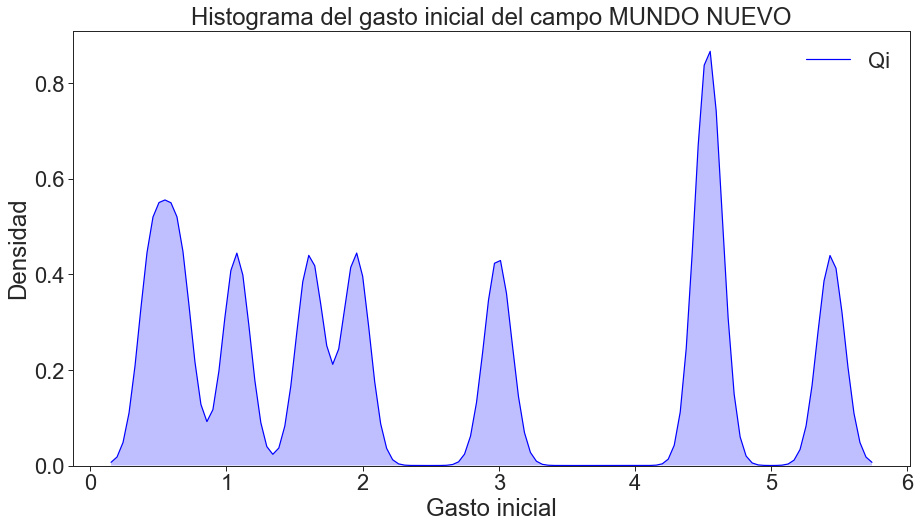

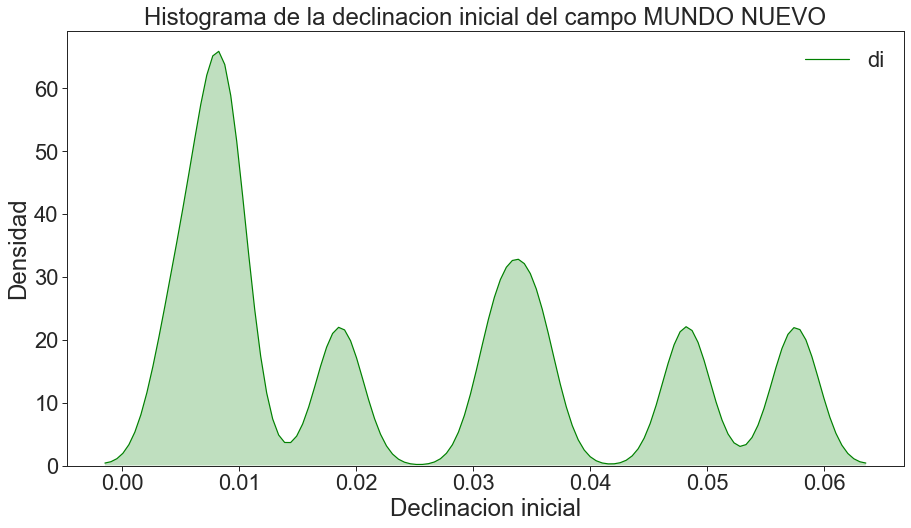

In [49]:
fig0, ax0 = plt.subplots(figsize=(15,8))  

sns.distplot(gasto.Qi_hist, hist=False, kde=True,label='Qi',color='Blue', kde_kws = {'shade': True, 'bw':0.1})
ax0.set_xlabel('Gasto inicial')
ax0.set_ylabel('Densidad')
plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
plt.legend(loc='best')

fig1, ax1 = plt.subplots(figsize=(15,8))  
sns.distplot(gasto.di_hyp, hist=False, kde=True,label='di',color='Green', kde_kws = {'shade': True,'bw':0.002})
ax1.set_xlabel('Declinacion inicial')
ax1.set_ylabel('Densidad')
plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
plt.legend(loc='best')

Nombre de campo: MALVA


'Número de pozos en MALVA: 8'

Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


Np           3.17
Gp          28.22
Cp           0.00
Wp           5.39
OOIP         0.00
Fr_aceite     inf
OGIP         0.00
Fr_gas        inf
Name: MALVA, dtype: float64

{'Qo base': 0.179708419355, 'Qg base': 1.12464516129, 'Qc base': 0.0}

maxima_produccion_pozo   1.57
produccion_total_pozo    1.97
dtype: float64

,produccion_mensual_campo
fecha,
2008-01-10,2.44


produccion_mensual_campo   2.44
dtype: float64

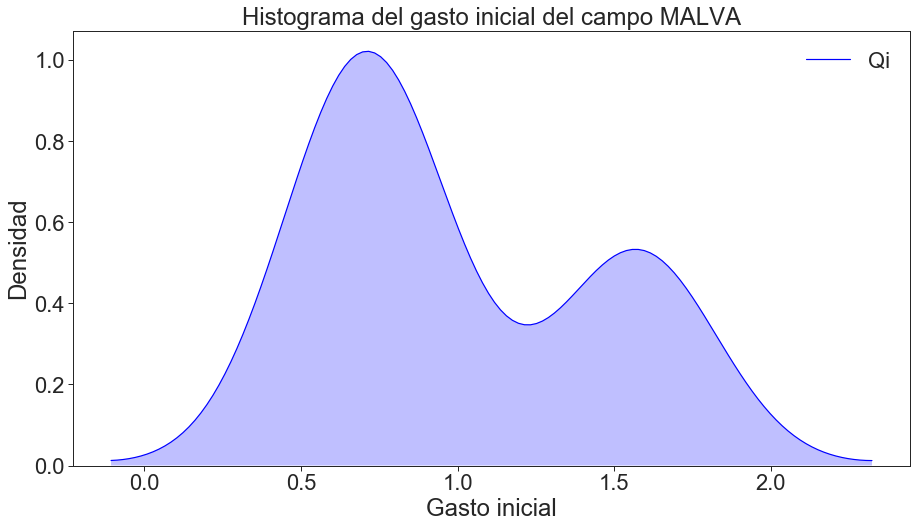

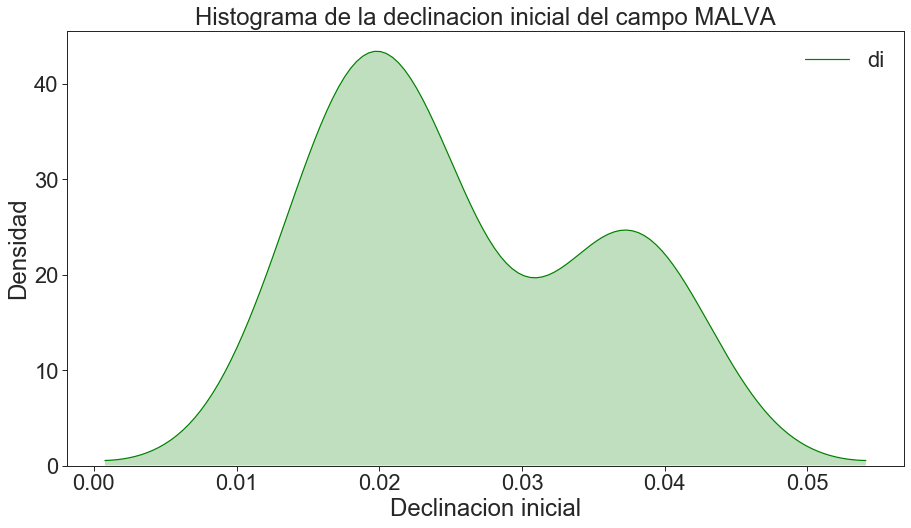

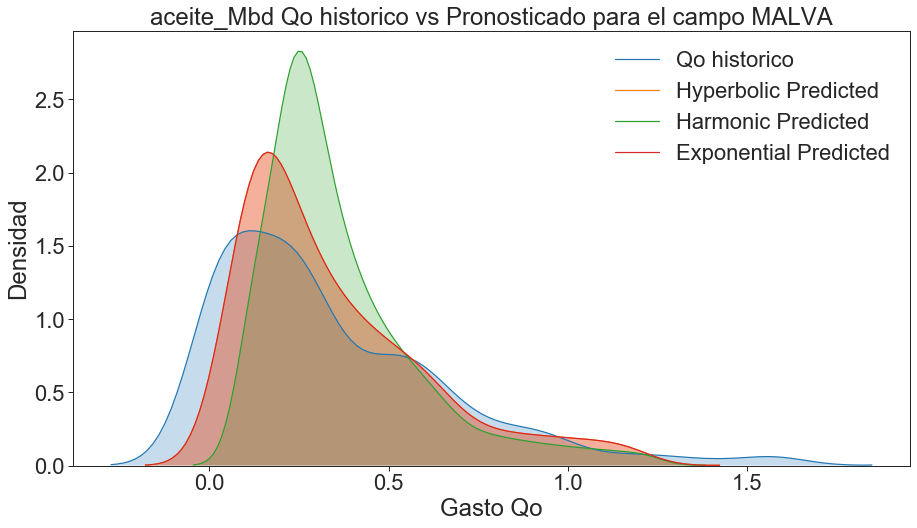

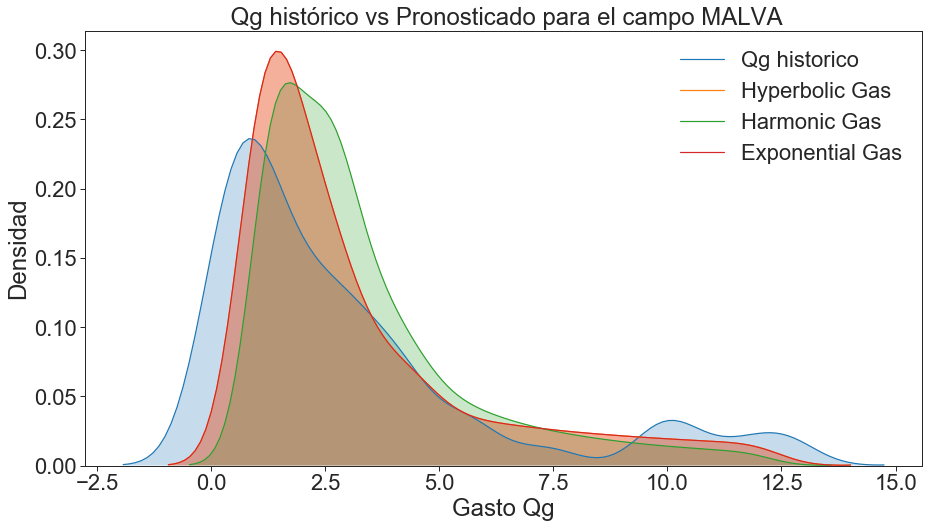

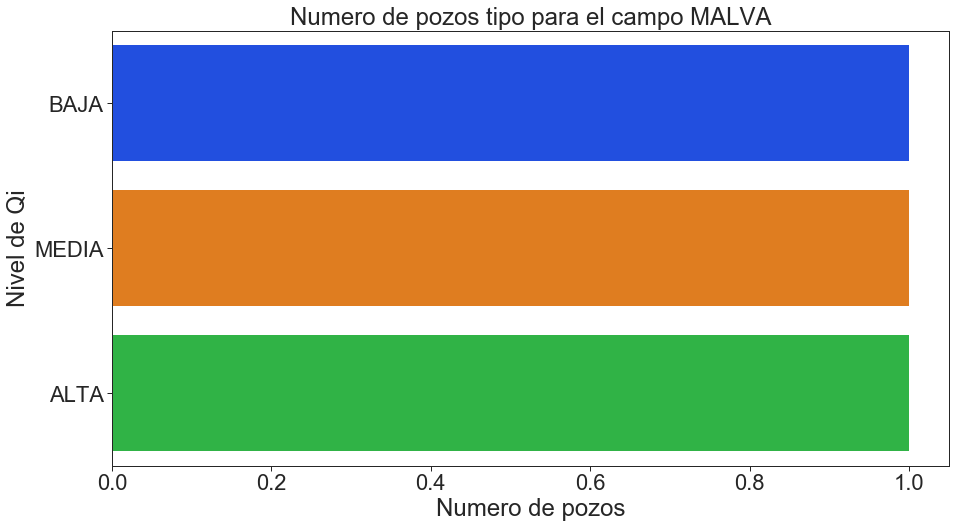

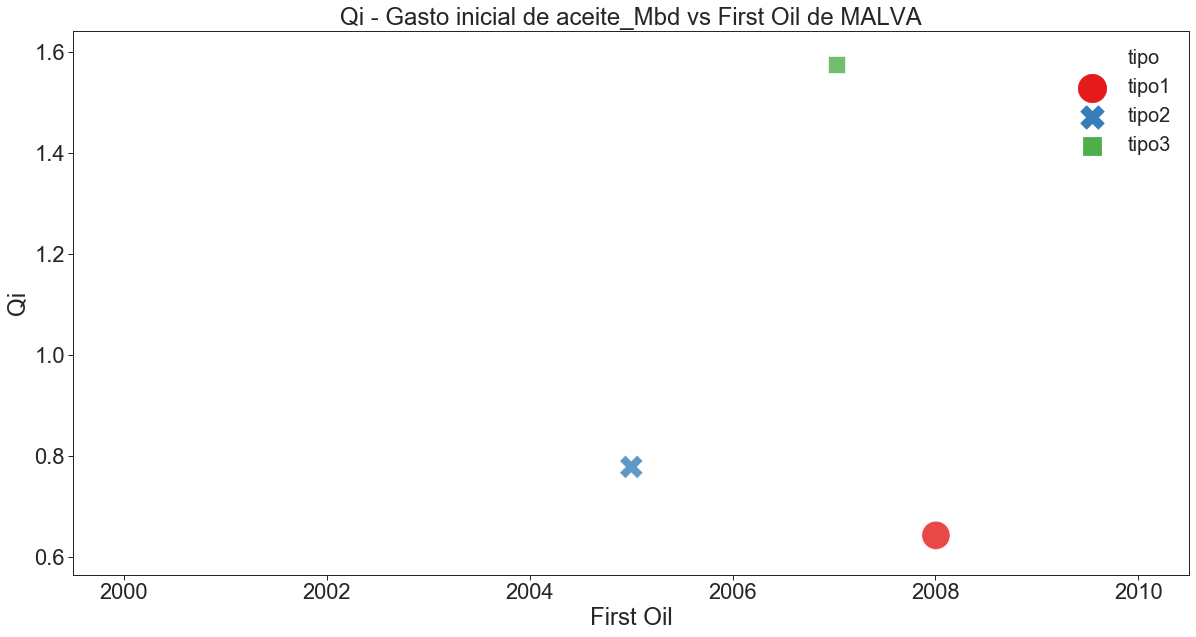

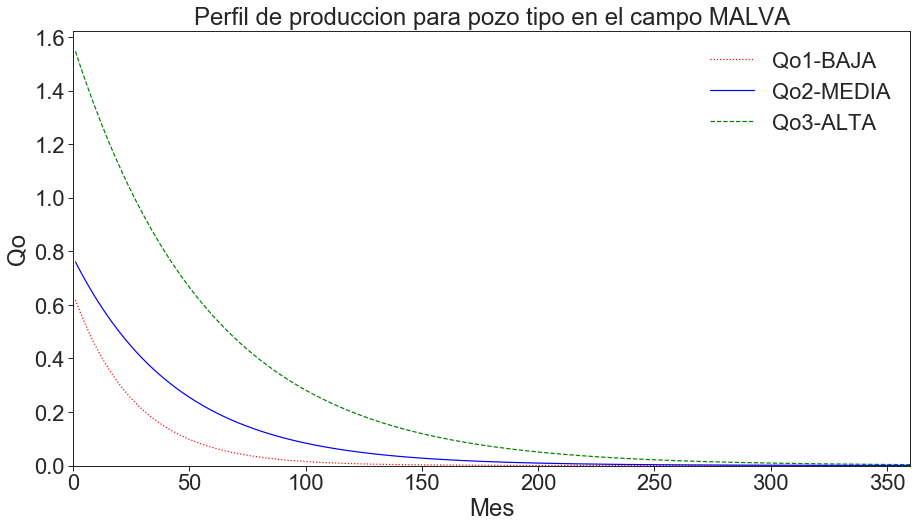

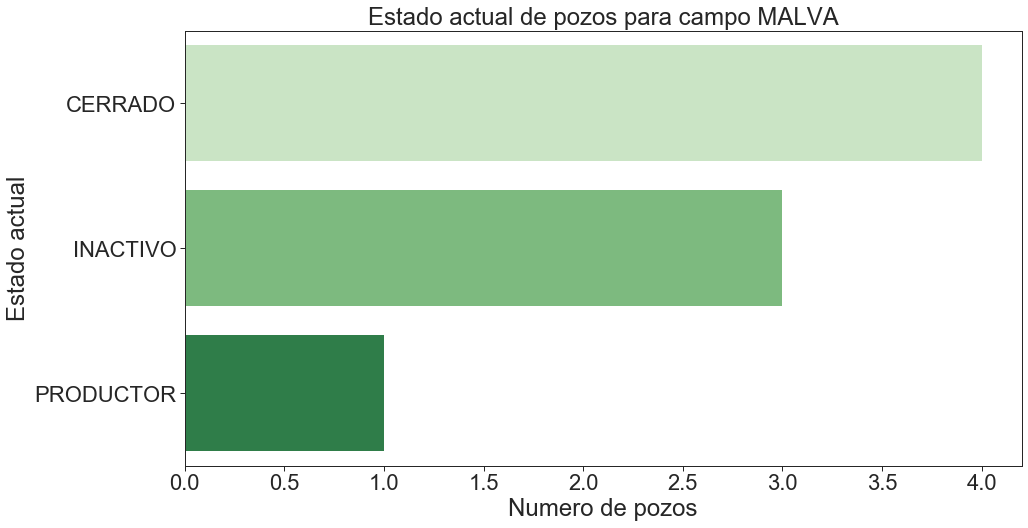

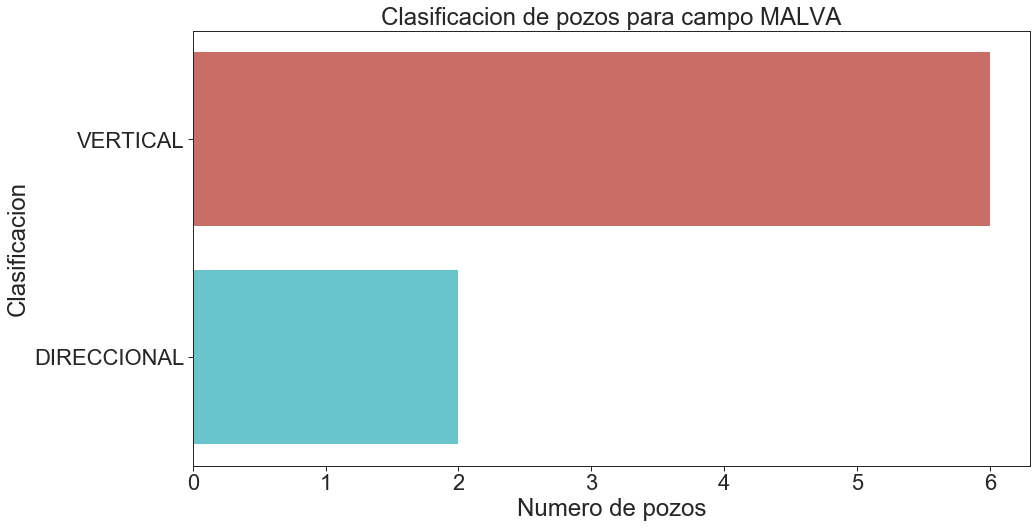

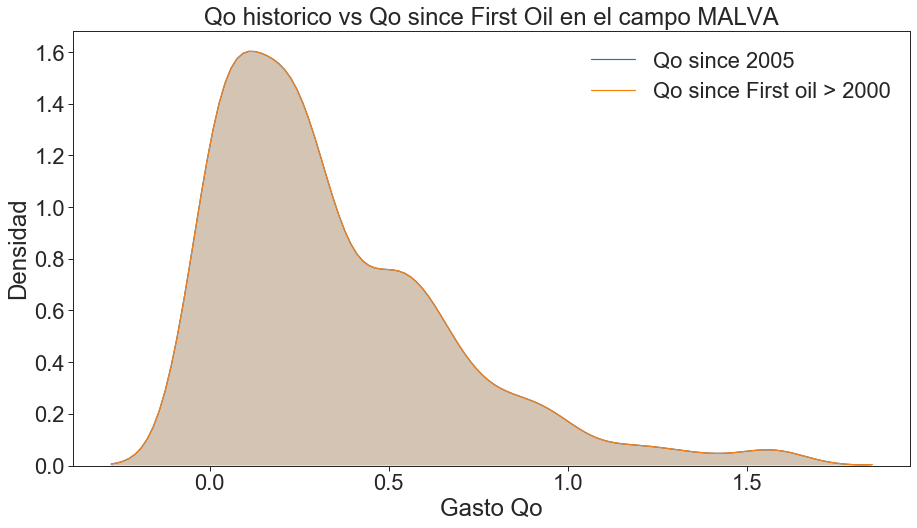

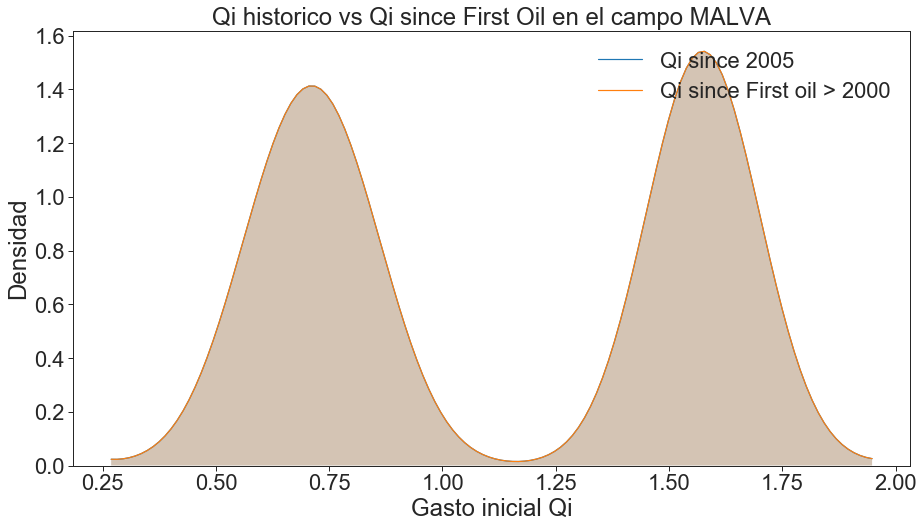

,SUPERFICIE KM2,UBICACION,NOMBRE,TIPO,VO CRUDO 1P (MMB),VO GAS 1P (MMMPC),PETROLEO CRUDO EQUIVALENTE 1P (MMBPCE),CRUDO 1P (MMB),GAS NATURAL 1P (MMBPCE),CONDENSADO 1P (MMB),VO CRUDO 2P (MMB),VO GAS 2P (MMMPC),PETROLEO CRUDO EQUIVALENTE 2P (MMBPCE),CRUDO 2P (MMB),GAS NATURAL 2P (MMBPCE),CONDENSADO 2P (MMB),VO CRUDO 3P (MMB),VO GAS 3P (MMMPC),PETROLEO CRUDO EQUIVALENTE 3P (MMBPCE),CRUDO 3P (MMB),GAS NATURAL 3P (MMBPCE),CONDENSADO 3P (MMB),PRODUCCION ACUMULADA CRUDO (MMB),PRODUCCION ACUMULADA GAS (MMMPC),PETROLEO CRUDO EQUIVALENTE (MMBPCE)
235,13.19,Terrestre,MALVA,Area,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,fecha,cuenca,contrato,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,campo,clasificacion,disponible,entidad,estado_actual,profundidad_total,profundidad_vertical,tipo_de_hidrocarburo,trayectoria,ubicacion,first_oil,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
pozo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MALVA-85,2020-01-01,CUENCAS DEL SURESTE,CNH-R01-L03-A11/2015,0.18,1.12,0.00,1.37,0.00,"2,007.00",MALVA,DESARROLLO,Disponible,CHIAPAS,PRODUCTOR,"3,796.00","2,977.00",ACEITE-GAS,DIRECCIONAL,TERRESTRE,2007-01-10,4739,0.01,1.57,149,0.09,0.09,0.22,1.01,2.32,1.01,0.00


8

3

,maxima_produccion_pozo,produccion_total_pozo
pozo,,
MALVA-85,1.57,1.97
MALVA-201,0.78,0.74
MALVA-83,0.64,0.45
MALVA-1,nan,0.00
MALVA-101,nan,0.00
MALVA-1A,nan,0.00
MALVA-1B,nan,0.00
MALVA-401,nan,0.00


,produccion_mensual_campo
fecha,
2008-01-10,2.44
2008-01-09,2.43
2008-01-07,2.41
2008-01-08,2.41
2008-01-06,2.31


,fecha,cuenca,contrato,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,campo,clasificacion,disponible,entidad,estado_actual,profundidad_total,profundidad_vertical,tipo_de_hidrocarburo,trayectoria,ubicacion,first_oil,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
pozo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MALVA-201,2013-01-05,CUENCAS DEL SURESTE,NaN,0.02,0.04,0.00,0.43,0.00,"2,003.00",MALVA,EXPLORATORIO,Disponible,CHIAPAS,INACTIVO,"3,450.00",nan,ACEITE-GAS,VERTICAL,TERRESTRE,2005-01-01,2926,0.01,0.78,80,0.12,0.12,0.18,0.73,1.01,0.73,0.00
MALVA-85,2020-01-01,CUENCAS DEL SURESTE,CNH-R01-L03-A11/2015,0.18,1.12,0.00,1.37,0.00,"2,007.00",MALVA,DESARROLLO,Disponible,CHIAPAS,PRODUCTOR,"3,796.00","2,977.00",ACEITE-GAS,DIRECCIONAL,TERRESTRE,2007-01-10,4739,0.01,1.57,149,0.09,0.09,0.22,1.01,2.32,1.01,0.00
MALVA-83,2014-01-08,CUENCAS DEL SURESTE,NaN,0.01,0.27,0.00,0.25,0.00,"2,008.00",MALVA,DESARROLLO,Disponible,CHIAPAS,INACTIVO,"3,272.00","3,044.30",ACEITE-GAS,DIRECCIONAL,TERRESTRE,2008-01-03,2197,-0.42,0.64,78,0.03,0.03,0.10,0.71,1.19,0.71,0.00


In [50]:
productividad()
display(info_reservas)
display(serie_base)
display(len(lista_pozos),len(unique_well_list))
display(resumen_produccion, produccion_mensual.head(),serie_status)

Nombre de campo: TOPEN


'Número de pozos en TOPEN: 5'

Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


Np           7.84
Gp          20.09
Cp           0.00
Wp           0.64
OOIP         0.00
Fr_aceite     inf
OGIP         0.00
Fr_gas        inf
Name: TOPEN, dtype: float64

{'Qo base': 0.0, 'Qg base': 0.0, 'Qc base': 0.0}

maxima_produccion_pozo   1.85
produccion_total_pozo    5.67
dtype: float64

,produccion_mensual_campo
fecha,
1980-01-01,2.55


produccion_mensual_campo   2.55
dtype: float64

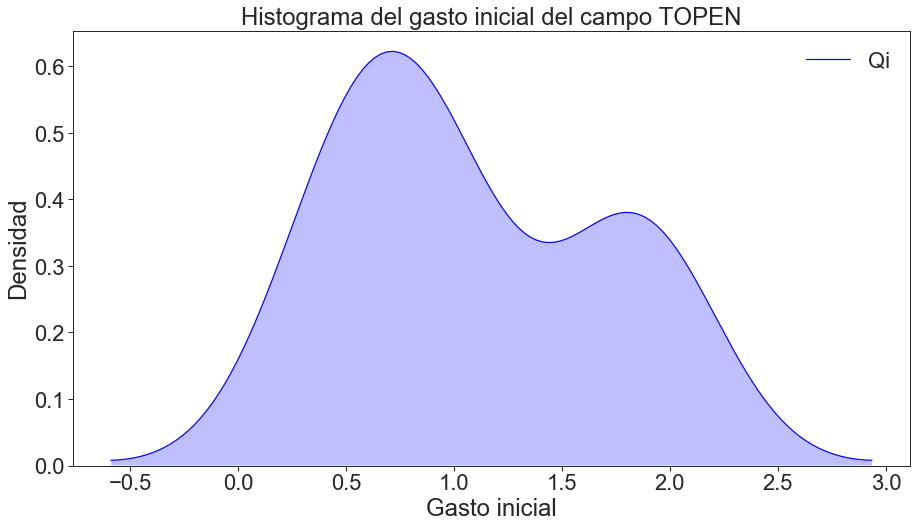

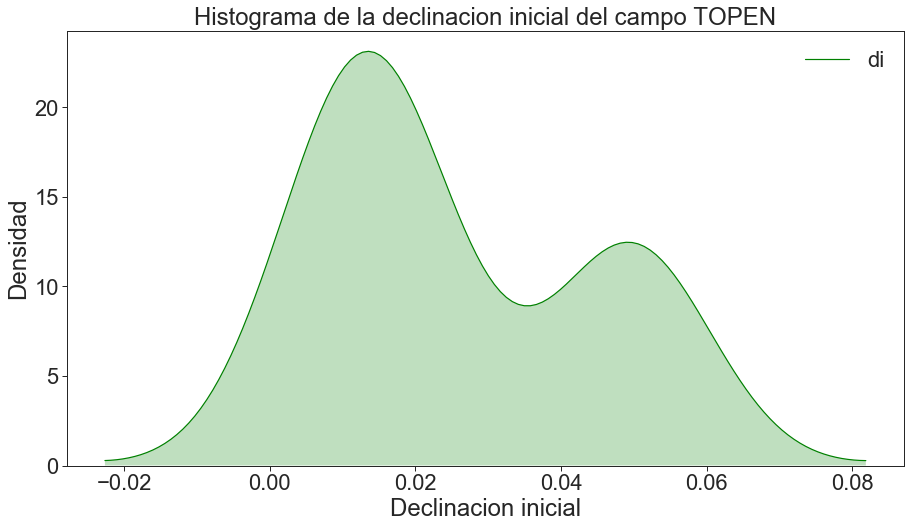

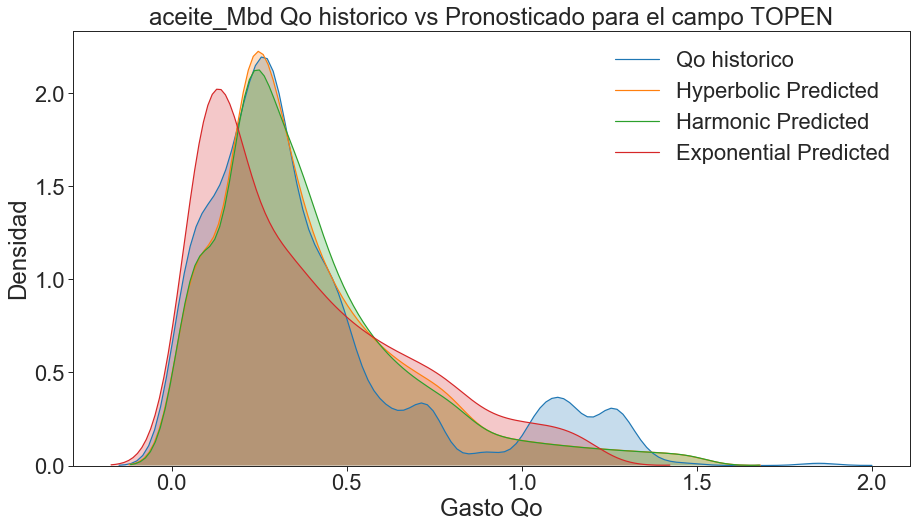

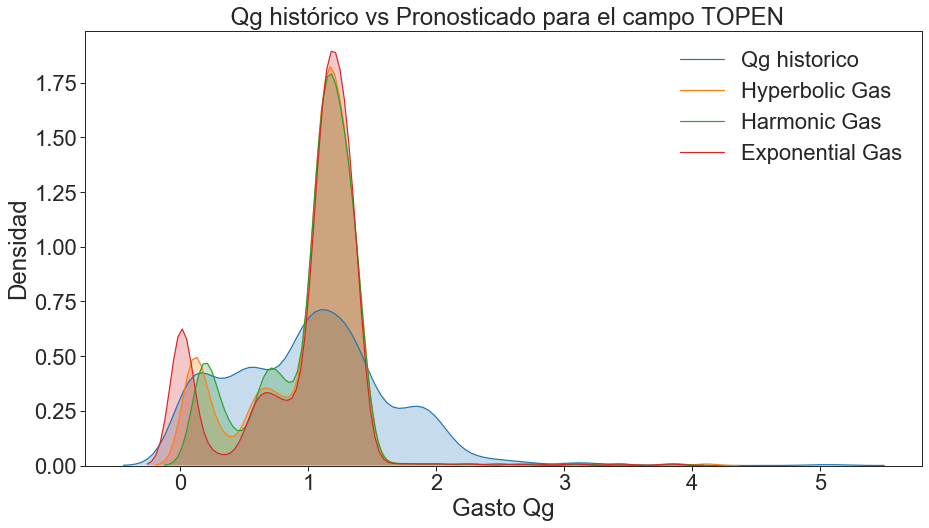

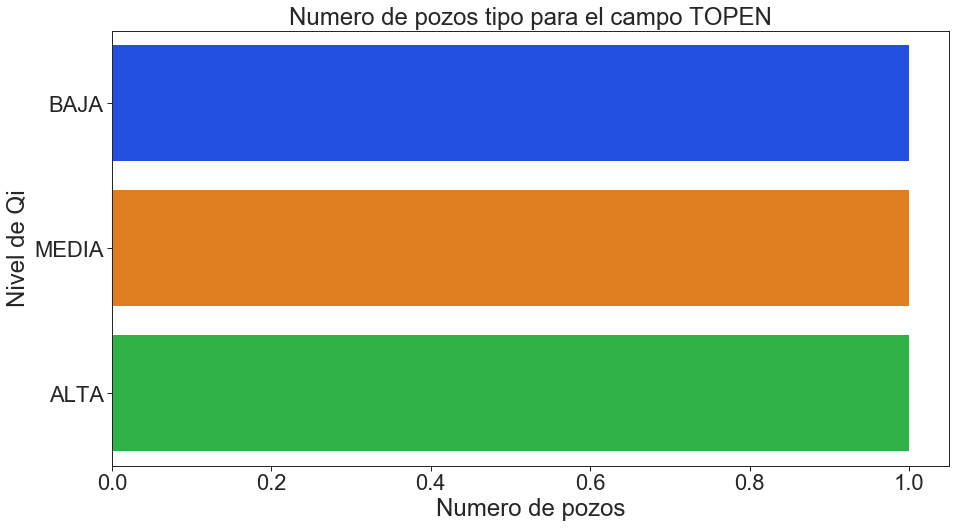

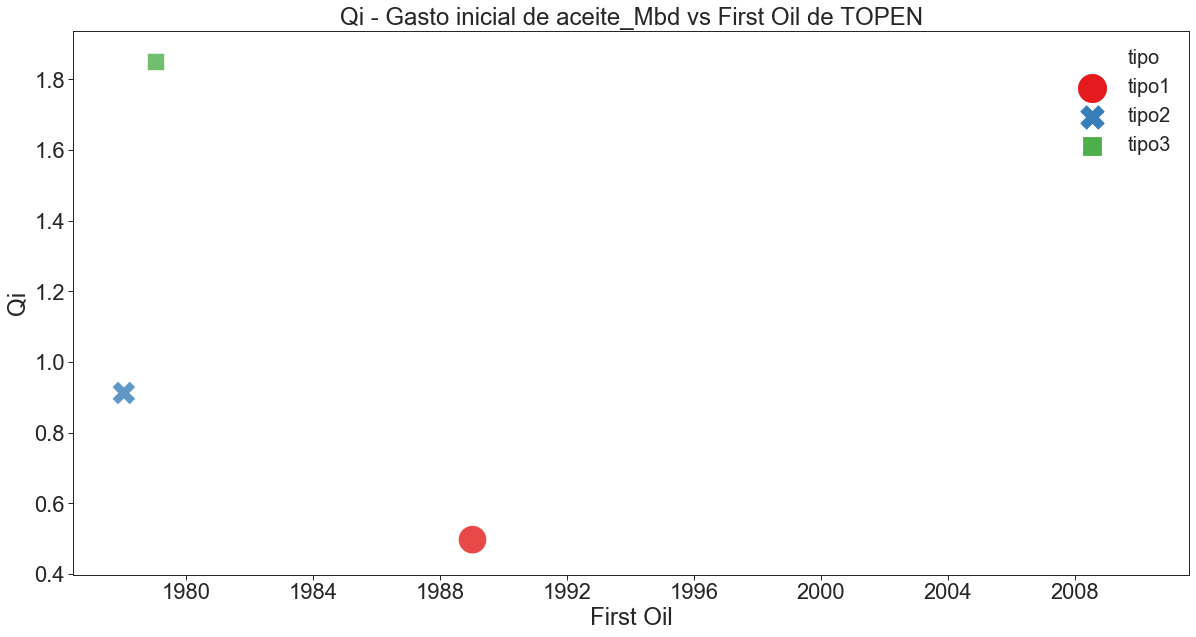

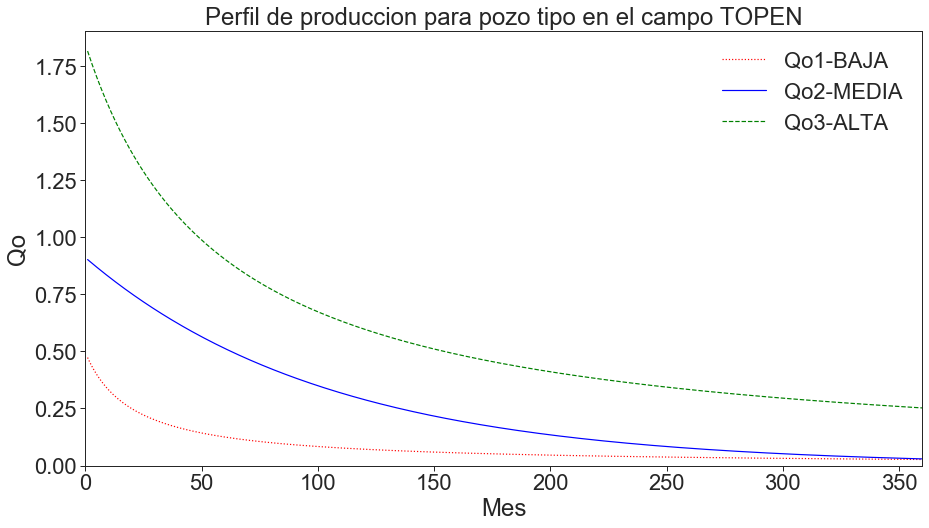

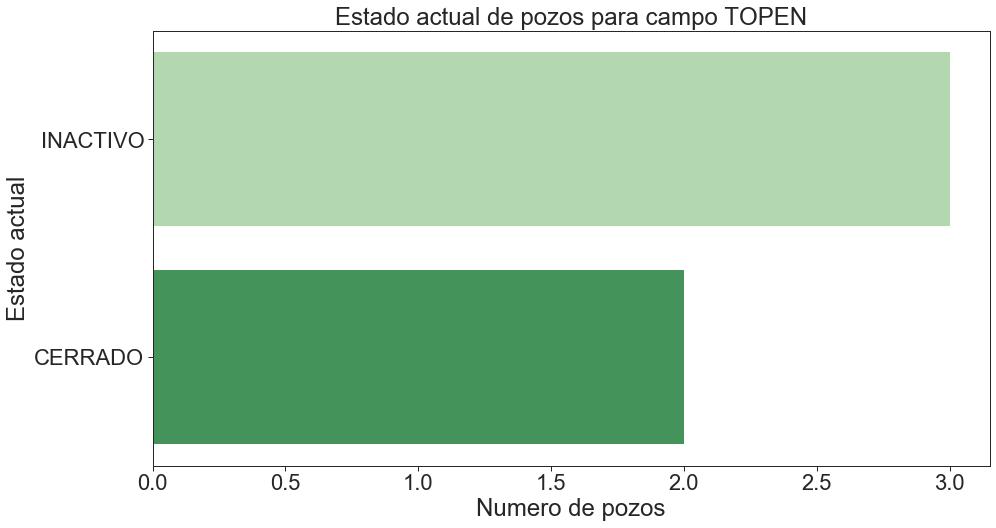

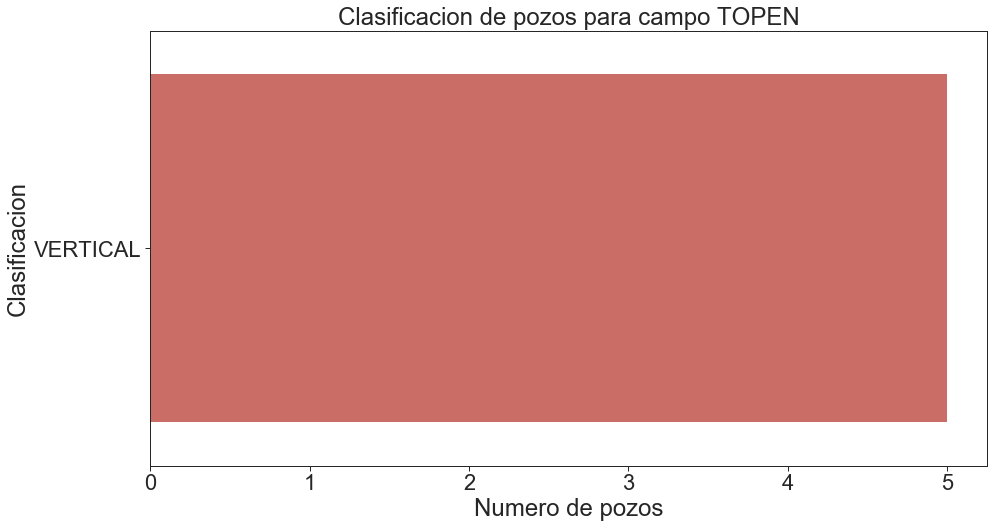

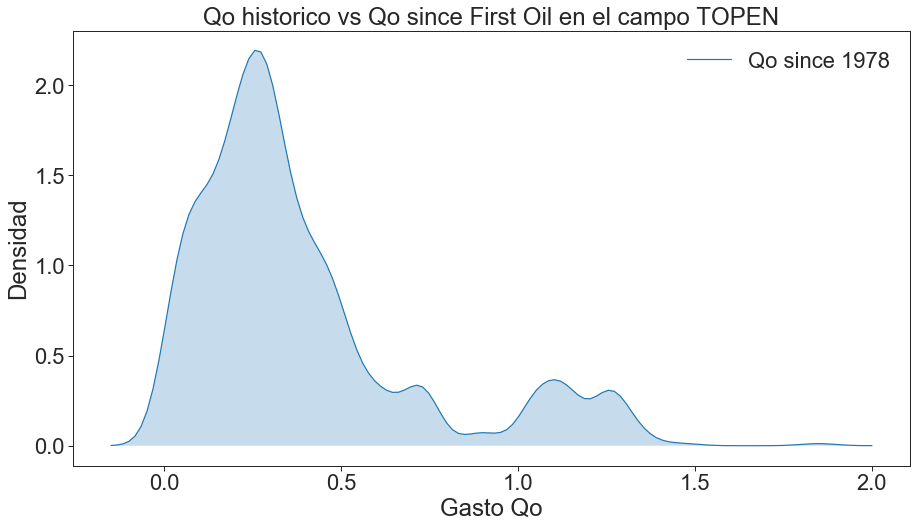

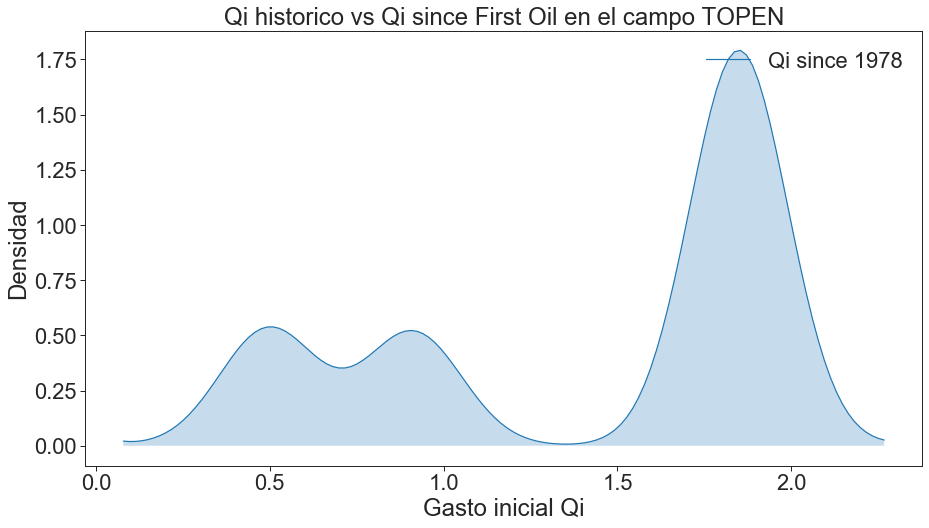

,SUPERFICIE KM2,UBICACION,NOMBRE,TIPO,VO CRUDO 1P (MMB),VO GAS 1P (MMMPC),PETROLEO CRUDO EQUIVALENTE 1P (MMBPCE),CRUDO 1P (MMB),GAS NATURAL 1P (MMBPCE),CONDENSADO 1P (MMB),VO CRUDO 2P (MMB),VO GAS 2P (MMMPC),PETROLEO CRUDO EQUIVALENTE 2P (MMBPCE),CRUDO 2P (MMB),GAS NATURAL 2P (MMBPCE),CONDENSADO 2P (MMB),VO CRUDO 3P (MMB),VO GAS 3P (MMMPC),PETROLEO CRUDO EQUIVALENTE 3P (MMBPCE),CRUDO 3P (MMB),GAS NATURAL 3P (MMBPCE),CONDENSADO 3P (MMB),PRODUCCION ACUMULADA CRUDO (MMB),PRODUCCION ACUMULADA GAS (MMMPC),PETROLEO CRUDO EQUIVALENTE (MMBPCE)
227,15.20,Terrestre,TOPEN,Area,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,fecha,cuenca,contrato,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,campo,clasificacion,disponible,entidad,estado_actual,profundidad_total,profundidad_vertical,tipo_de_hidrocarburo,trayectoria,ubicacion,first_oil,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
pozo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


5

3

,maxima_produccion_pozo,produccion_total_pozo
pozo,,
TOPEN-3,1.85,5.67
TOPEN-1,0.91,1.79
TOPEN-21,0.50,0.39
TOPEN-101,nan,0.00
TOPEN-22,nan,0.00


,produccion_mensual_campo
fecha,
1980-01-01,2.55
1979-01-12,1.93
1984-01-12,1.81
1985-01-03,1.81
1985-01-04,1.81


,fecha,cuenca,contrato,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,campo,clasificacion,disponible,entidad,estado_actual,profundidad_total,profundidad_vertical,tipo_de_hidrocarburo,trayectoria,ubicacion,first_oil,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
pozo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TOPEN-1,2014-01-10,CUENCAS DEL SURESTE,NaN,0.01,0.02,0.00,0.00,0.00,"1,978.00",TOPEN,EXPLORATORIO,Disponible,CHIAPAS,INACTIVO,"3,625.00",nan,ACEITE NEGRO,VERTICAL,TERRESTRE,1978-01-12,13147,-0.84,0.91,121,0.26,0.26,0.32,0.54,0.61,0.54,0.00
TOPEN-3,2018-01-09,CUENCAS DEL SURESTE,CNH-R01-L03-A25/2015,0.05,0.29,0.00,0.02,0.00,"1,979.00",TOPEN,DESARROLLO,Disponible,CHIAPAS,INACTIVO,"3,436.00",nan,ACEITE NEGRO,VERTICAL,TERRESTRE,1979-01-12,14242,-0.70,1.85,421,0.08,0.18,0.18,1.05,1.05,1.06,0.00
TOPEN-21,2013-01-05,CUENCAS DEL SURESTE,NaN,0.05,0.03,0.00,0.02,0.00,"1,988.00",TOPEN,DESARROLLO,Disponible,CHIAPAS,INACTIVO,"3,650.00",nan,ACEITE NEGRO,VERTICAL,TERRESTRE,1989-01-07,8764,-0.39,0.50,125,0.04,0.04,0.04,0.06,0.13,0.00,0.00


In [51]:
productividad()
display(info_reservas)
display(serie_base)
display(len(lista_pozos),len(unique_well_list))
display(resumen_produccion, produccion_mensual.head(),serie_status)

Nombre de campo: AMATITLAN


'Número de pozos en AMATITLAN: 20'

Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


Np            0.22
Gp            1.20
Cp            0.00
Wp            0.03
OOIP        106.68
Fr_aceite     0.00
OGIP         85.12
Fr_gas        0.01
Name: AMATITLAN, dtype: float64

{'Qo base': 0.0047272479022, 'Qg base': 0.02986286028282, 'Qc base': 0.0}

maxima_produccion_pozo   0.20
produccion_total_pozo    0.04
dtype: float64

,produccion_mensual_campo
fecha,
2018-01-07,0.24


produccion_mensual_campo   0.24
dtype: float64

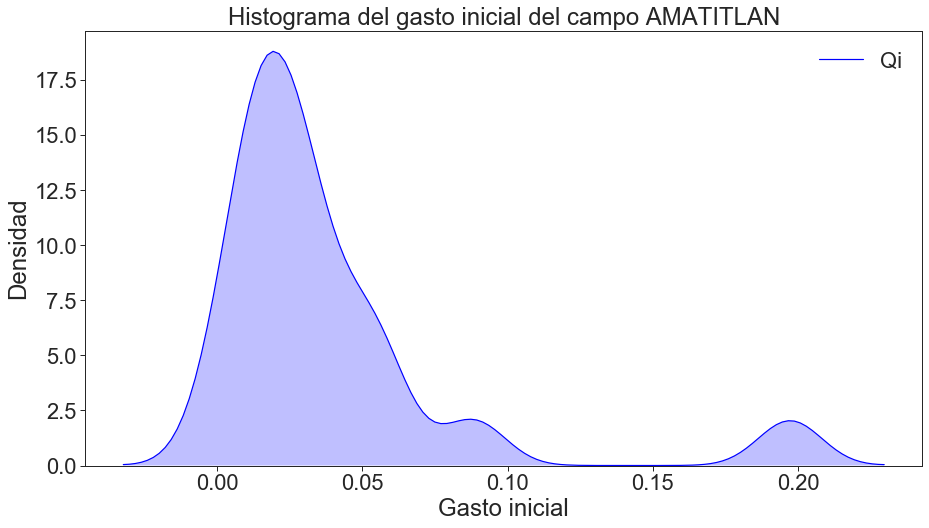

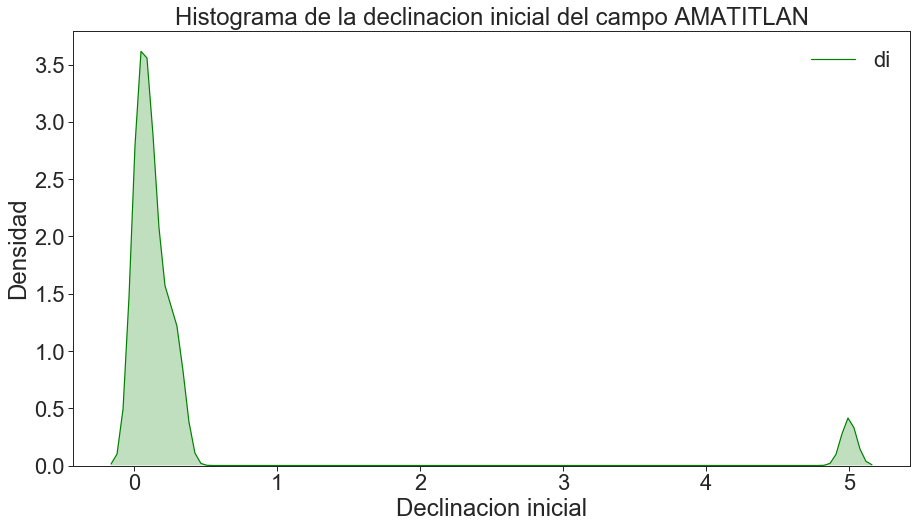

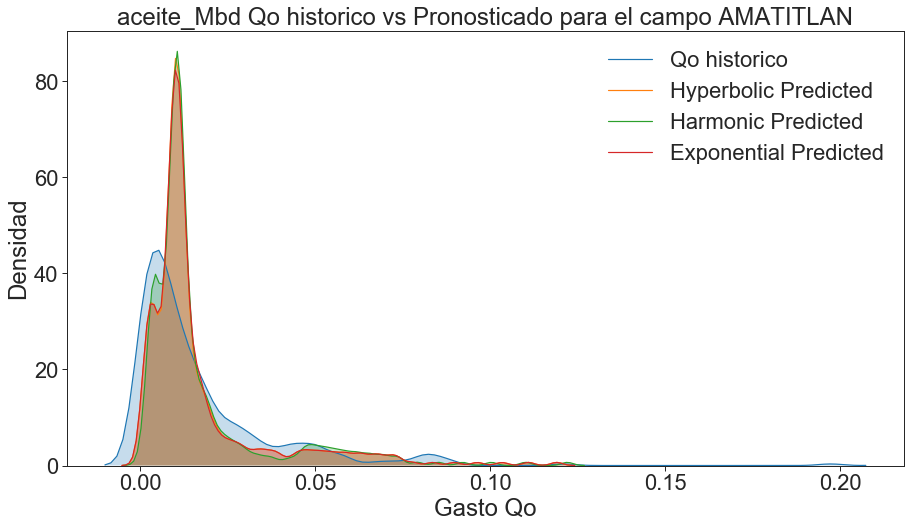

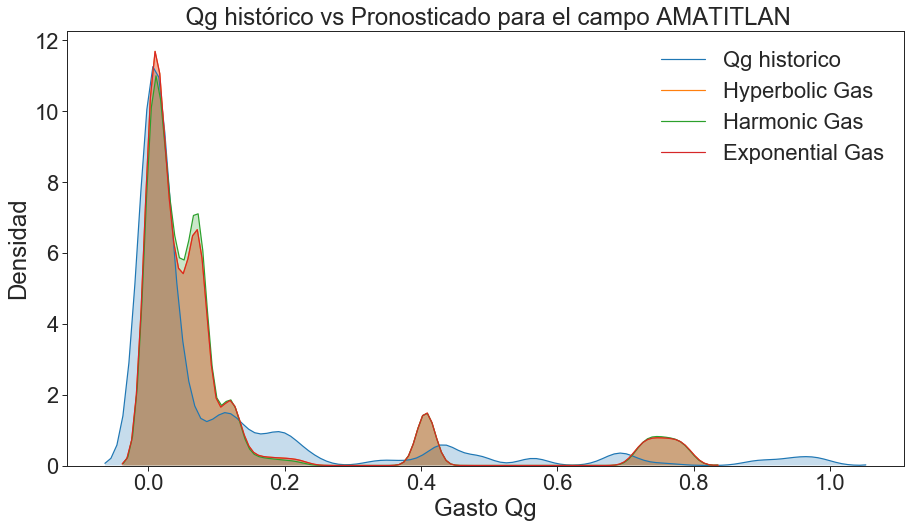

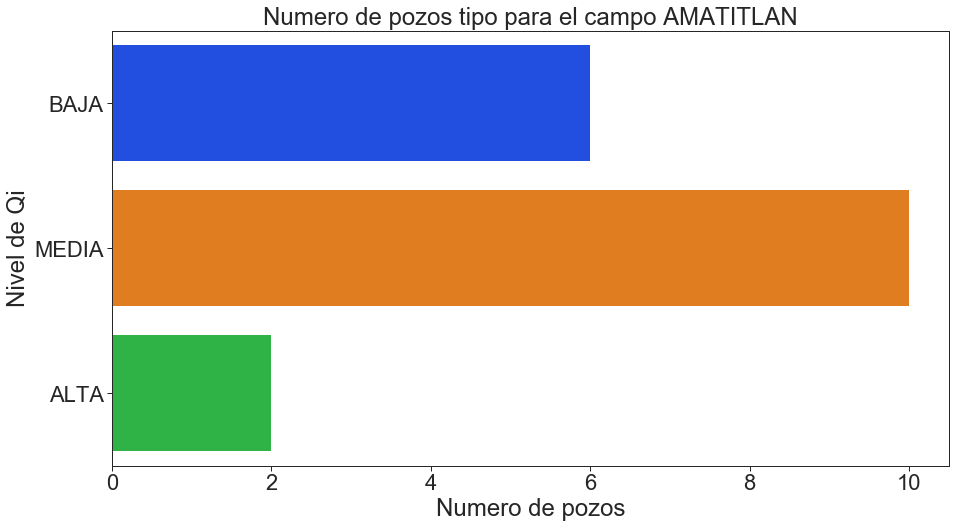

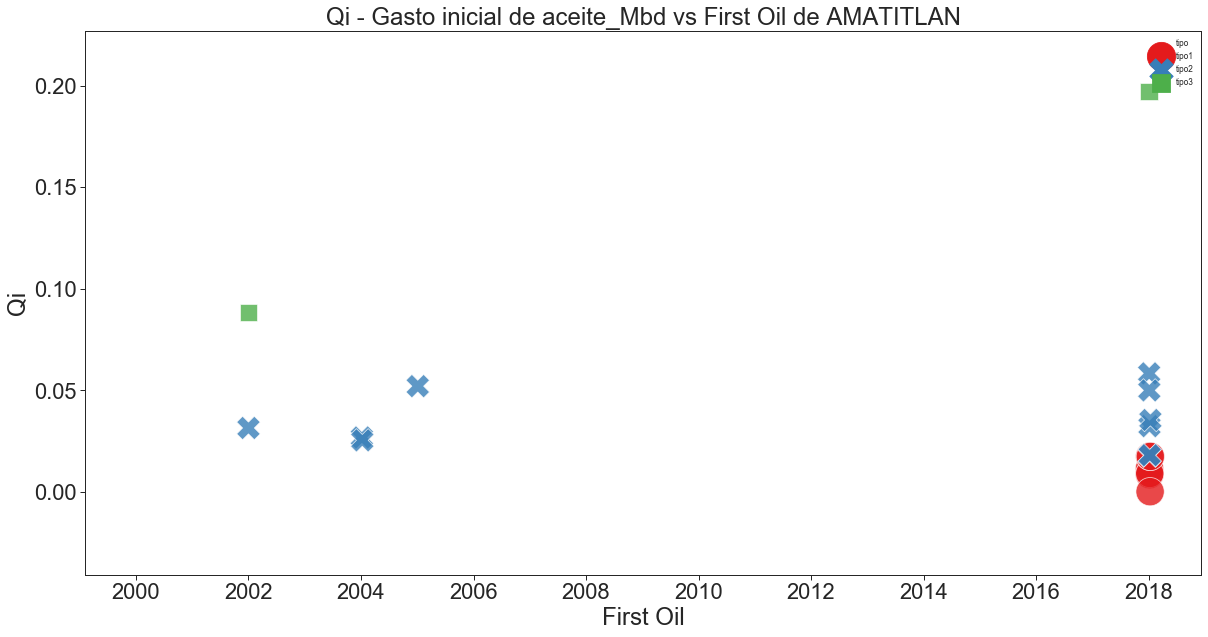

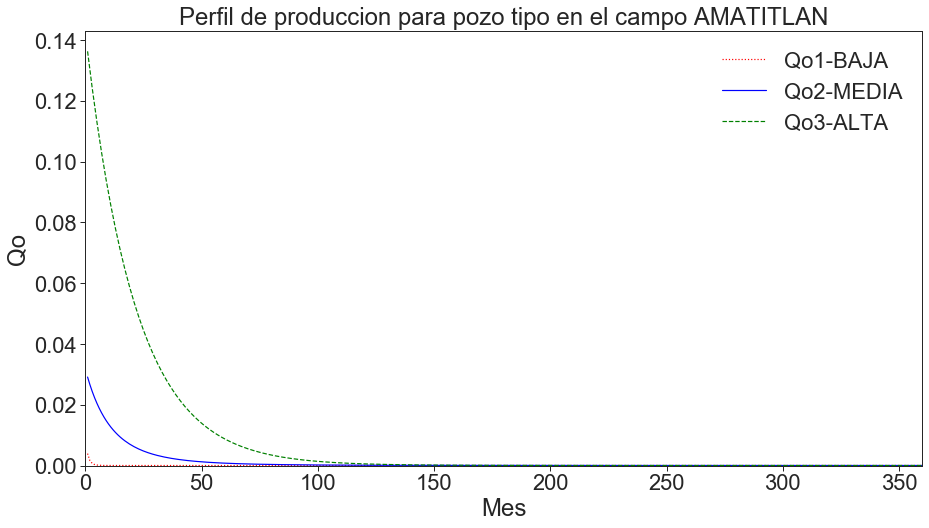

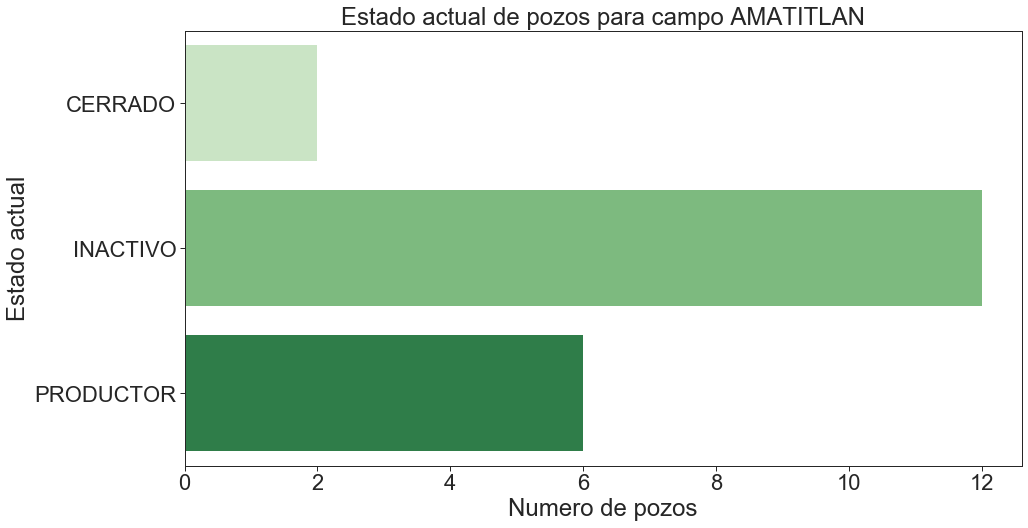

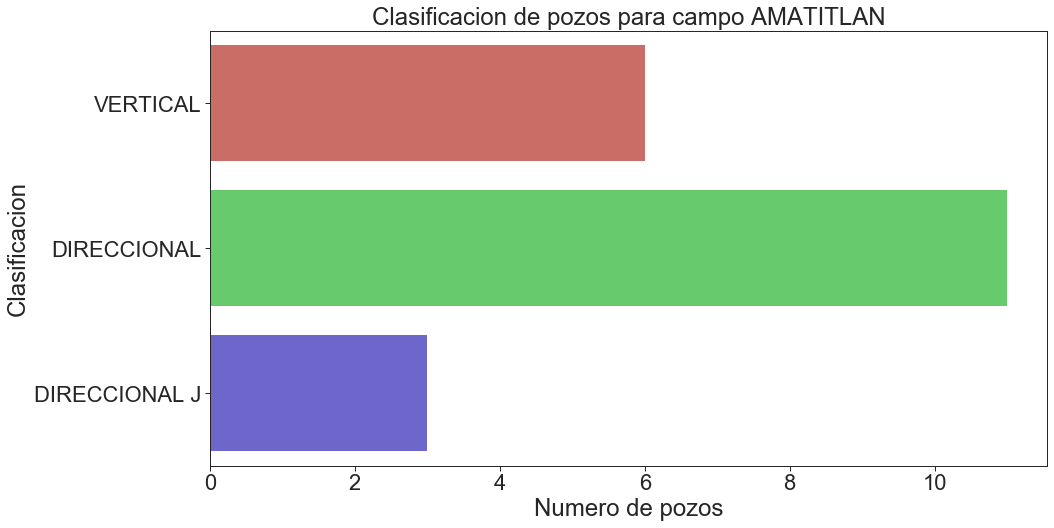

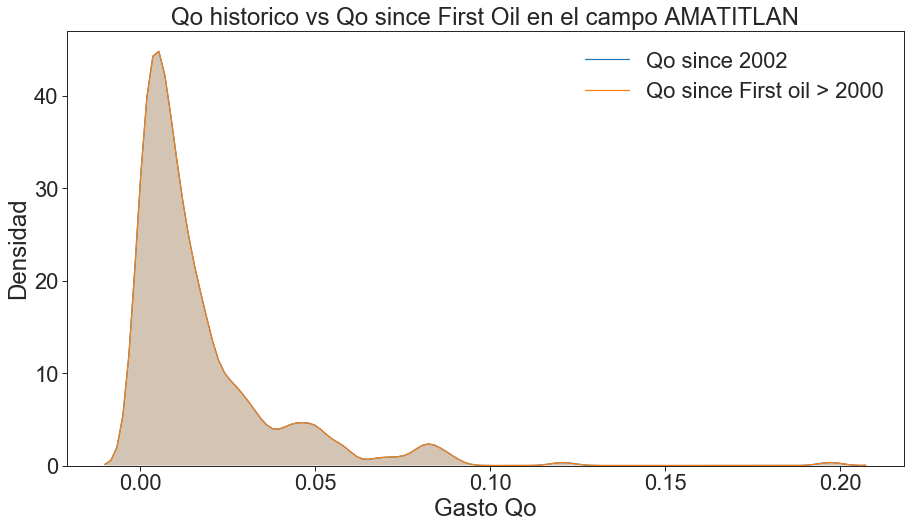

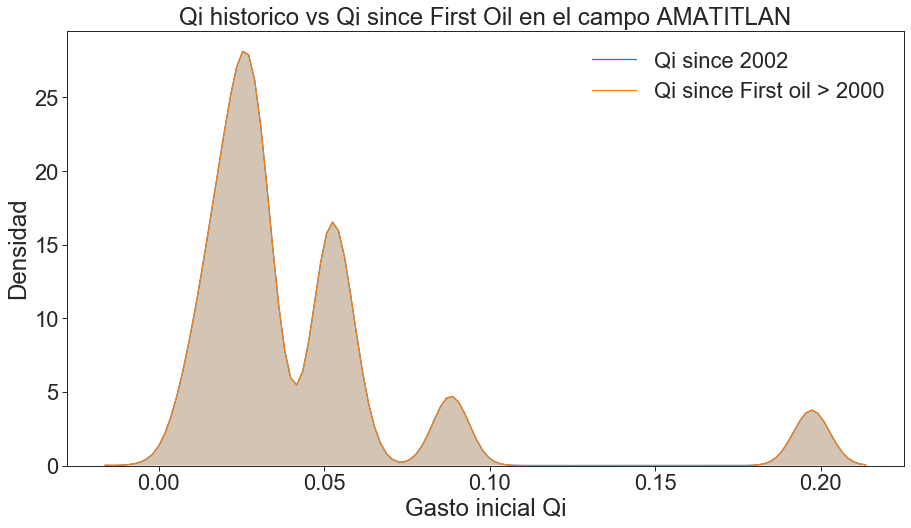

,SUPERFICIE KM2,UBICACION,NOMBRE,TIPO,VO CRUDO 1P (MMB),VO GAS 1P (MMMPC),PETROLEO CRUDO EQUIVALENTE 1P (MMBPCE),CRUDO 1P (MMB),GAS NATURAL 1P (MMBPCE),CONDENSADO 1P (MMB),VO CRUDO 2P (MMB),VO GAS 2P (MMMPC),PETROLEO CRUDO EQUIVALENTE 2P (MMBPCE),CRUDO 2P (MMB),GAS NATURAL 2P (MMBPCE),CONDENSADO 2P (MMB),VO CRUDO 3P (MMB),VO GAS 3P (MMMPC),PETROLEO CRUDO EQUIVALENTE 3P (MMBPCE),CRUDO 3P (MMB),GAS NATURAL 3P (MMBPCE),CONDENSADO 3P (MMB),PRODUCCION ACUMULADA CRUDO (MMB),PRODUCCION ACUMULADA GAS (MMMPC),PETROLEO CRUDO EQUIVALENTE (MMBPCE)
226,156.96,Terrestre,AMATITLAN,Campo,106.68,85.12,2.77,1.83,4.61,0.00,936.56,747.28,42.15,25.16,82.98,0.00,"4,170.50","3,327.63",251.74,149.80,497.85,0.00,0.22,1.14,0.44


,fecha,cuenca,contrato,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,campo,clasificacion,disponible,entidad,estado_actual,profundidad_total,profundidad_vertical,tipo_de_hidrocarburo,trayectoria,ubicacion,first_oil,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
pozo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AMATITLAN-1718DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.01,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,PRODUCTOR,"1,905.00","1,852.00",ACEITE-GAS,DIRECCIONAL,TERRESTRE,2018-01-04,727,0.72,0.06,21,0.01,0.01,0.01,0.03,0.03,0.03,0.00
AMATITLAN-1659DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.00,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,902.00","1,844.40",NaN,DIRECCIONAL,TERRESTRE,2018-01-06,725,-0.73,0.01,8,0.00,0.00,0.00,0.04,0.05,0.04,0.00
AMATITLAN-1716DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.01,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,PRODUCTOR,"1,874.00",nan,NaN,DIRECCIONAL,TERRESTRE,2018-01-06,725,5.45,0.02,19,0.00,0.00,0.00,0.01,0.02,0.01,0.00
AMATITLAN-1754DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.00,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,905.00","1,850.00",ACEITE Y GAS,DIRECCIONAL,TERRESTRE,2018-01-07,724,-0.67,0.01,5,0.00,0.00,0.00,0.01,0.01,0.01,0.00
AMATITLAN-1752DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.00,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,PRODUCTOR,"1,889.00","1,843.00",ACEITE Y GAS,DIRECCIONAL,TERRESTRE,2018-01-08,723,-0.76,0.02,17,0.00,0.00,0.00,0.01,0.02,0.01,0.00
AMATITLAN-1643DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.01,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,PRODUCTOR,"1,910.00","1,850.00",NaN,DIRECCIONAL,TERRESTRE,2018-01-08,723,-0.28,0.02,15,0.00,0.00,0.00,0.01,0.02,0.01,0.00


20

18

,maxima_produccion_pozo,produccion_total_pozo
pozo,,
AMATITLAN-1708DES,0.20,0.04
AMATITLAN-3,0.09,0.04
AMATITLAN-1718DES,0.06,0.01
AMATITLAN-1469,0.05,0.02
AMATITLAN-1649DES,0.05,0.01
AMATITLAN-1792,0.04,0.00
AMATITLAN-1704DES,0.03,0.00
AMATITLAN-3D,0.03,0.01
AMATITLAN-1489,0.03,0.01


,produccion_mensual_campo
fecha,
2018-01-07,0.24
2018-01-08,0.23
2018-01-09,0.22
2018-01-03,0.22
2018-01-10,0.21


,fecha,cuenca,contrato,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,campo,clasificacion,disponible,entidad,estado_actual,profundidad_total,profundidad_vertical,tipo_de_hidrocarburo,trayectoria,ubicacion,first_oil,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
pozo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AMATITLAN-3,2004-01-05,TAMPICO-MISANTLA,NaN,0.04,0.70,0.00,0.00,0.00,"1,969.00",AMATITLAN,DESARROLLO,Disponible,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"4,362.00",nan,ACEITE,VERTICAL,TERRESTRE,2002-01-01,734,-0.03,0.09,24,0.04,0.04,0.05,0.72,0.72,0.72,0.00
AMATITLAN-3D,2004-01-06,TAMPICO-MISANTLA,NaN,0.00,0.00,0.00,0.00,0.00,"1,974.00",AMATITLAN,DESARROLLO,Disponible,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,250.00","1,250.00",ACEITE,VERTICAL,TERRESTRE,2002-01-01,735,-0.87,0.03,29,0.01,0.01,0.01,0.04,0.06,0.04,0.00
AMATITLAN-1489,2018-01-02,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.00,0.00,0.00,0.00,"2,003.00",AMATITLAN,DESARROLLO,Disponible,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,830.00","1,830.00",ACEITE,VERTICAL,TERRESTRE,2004-01-07,5109,-0.57,0.03,50,0.01,0.01,0.01,0.01,0.01,0.01,0.00
AMATITLAN-2A,2010-01-11,TAMPICO-MISANTLA,NaN,0.01,0.00,0.00,0.02,0.00,"2,004.00",AMATITLAN,DESARROLLO,Disponible,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,759.00","1,759.00",ACEITE,VERTICAL,TERRESTRE,2004-01-10,2193,-0.16,0.03,48,0.01,0.01,0.01,0.01,0.01,0.01,0.00
AMATITLAN-1469,2019-01-08,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.01,0.36,0.00,0.00,0.00,"2,004.00",AMATITLAN,DESARROLLO,Disponible,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,792.00","1,722.00",ACEITE,DIRECCIONAL,TERRESTRE,2005-01-04,5117,-0.39,0.05,58,0.01,0.01,0.01,0.07,0.07,0.07,0.00
AMATITLAN-1708DES,2019-01-08,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.03,0.34,0.00,0.01,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,968.00",nan,NaN,DIRECCIONAL,TERRESTRE,2018-01-02,371,-0.06,0.20,19,0.03,0.03,0.04,0.41,0.41,0.41,0.00
AMATITLAN-1718DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.01,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,PRODUCTOR,"1,905.00","1,852.00",ACEITE-GAS,DIRECCIONAL,TERRESTRE,2018-01-04,727,0.72,0.06,21,0.01,0.01,0.01,0.03,0.03,0.03,0.00
AMATITLAN-1649DES,2019-01-08,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.01,0.13,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,975.00",nan,NaN,DIRECCIONAL J,TERRESTRE,2018-01-05,368,-0.57,0.05,16,0.02,0.02,0.02,0.12,0.12,0.12,0.00
AMATITLAN-1659DES,2020-01-01,TAMPICO-MISANTLA,AE-0382-3M - AMATITLAN,0.00,0.00,0.00,0.00,0.00,"2,018.00",AMATITLAN,DESARROLLO,Confidencial,VERACRUZ DE IGNACIO DE LA LLAVE,INACTIVO,"1,902.00","1,844.40",NaN,DIRECCIONAL,TERRESTRE,2018-01-06,725,-0.73,0.01,8,0.00,0.00,0.00,0.04,0.05,0.04,0.00


In [3]:
productividad()
display(info_reservas)
display(serie_base)
display(len(lista_pozos),len(unique_well_list))
display(resumen_produccion, produccion_mensual.head(),serie_status)

In [4]:
display(estadistica)

,aceite_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,agua_Mbd,condensado_Mbd,ano_de_perforacion,profundidad_total,profundidad_vertical,days_online,declinacion,Qi_hist,mes,exponencial,hiperbolica,harmonica,gas_hiperbolica,gas_harmonica,gas_exponencial,condensado
count,369.00,369.00,369.00,369.00,369.00,369.00,369.00,279.00,369.00,351.00,369.00,369.00,369.00,369.00,369.00,369.00,369.00,369.00,369.00
mean,0.02,0.11,0.00,0.00,0.00,"2,005.30","1,971.23","1,734.40","1,222.29",0.67,0.04,16.84,0.02,0.02,0.02,0.11,0.11,0.11,0.00
std,0.02,0.21,0.00,0.01,0.00,15.31,655.18,171.90,"1,584.78",3.40,0.04,13.96,0.02,0.02,0.02,0.19,0.19,0.19,0.00
min,0.00,0.00,0.00,0.00,0.00,"1,969.00","1,250.00","1,250.00",0.00,-0.97,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,"2,003.00","1,792.00","1,722.00",10.00,-0.27,0.03,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00
50%,0.01,0.01,0.00,0.00,0.00,"2,004.00","1,830.00","1,779.00",367.00,-0.00,0.03,13.00,0.01,0.01,0.01,0.04,0.04,0.04,0.00
75%,0.02,0.11,0.00,0.00,0.00,"2,018.00","1,910.00","1,830.00","2,187.00",0.10,0.05,24.00,0.02,0.02,0.02,0.07,0.07,0.07,0.00
max,0.20,0.99,0.00,0.05,0.00,"2,018.00","4,362.00","1,852.00","5,117.00",26.99,0.20,58.00,0.12,0.12,0.12,0.80,0.79,0.80,0.00
